In [1]:
import copy
import os
import scipy.io as sio
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np
import scipy

from yass.evaluate.stability import *
from yass.evaluate.util import *
from yass.geometry import parse, find_channel_neighbors
from yass.deconvolute.ind_run import run

from deconv_exp_utils import *

from tqdm import tqdm
#import mpld3

from deconv_exp_utils import vis_chan, recon

%matplotlib inline

/home/hooshmand/Documents/github/yassenv/local/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
base_dir = '/ssd/data/peter/ej49_dataset'

raw = os.path.join(base_dir, 'ej49_data1_set1.bin')
geom = os.path.join(base_dir, 'ej49_geometry1.txt')
st_file = os.path.join(base_dir, 'groundtruth_ej49_data1_set1.mat')

rbi = RecordingBatchIterator(
    rec_file=raw, n_chan=49, batch_time_samples=1000000,
    geom_file=geom, n_batches=6, radius=70, sample_rate=20000,
    whiten=False)

In [3]:
LOAD = True

temp_file = 'gold_temp.npy'
align_temp_file = 'align_gold_temp.npy'
gold_sp_file = 'gold_sp.npy'

if not LOAD:
    gold_sp = sio.loadmat(st_file)
    gold_sp = np.append(gold_sp['spt_gt'], gold_sp['L_gt'])
    gold_sp = gold_sp.reshape([2, len(gold_sp) // 2]).T

    mwc = MeanWaveCalculator(batch_reader=rbi, spike_train=gold_sp, window=range(-20, 30))
    mwc.compute_templates(6)
    mwc_temps = mwc.templates
    np.save(temp_file, mwc_temps)
    np.save(gold_sp_file, gold_sp)

    # align templates or not
    align_temps = []
    n_unit = mwc_temps.shape[2]
    for unit in tqdm(range(n_unit)):
        t, _ = optimal_aligned_compress(mwc_temps[:, :, unit])
        align_temps.append(t.T)
    align_temps = np.array(align_temps).T
    align_temps = scipy.signal.resample(align_temps, int(align_temps.shape[0] / 5.))
    np.save(align_temp_file, align_temps)

else:
    gold_sp = np.load(gold_sp_file)
    mwc_temps = np.load(temp_file)
    align_temps = np.load(align_temp_file)

In [4]:
if False:
    only_units = [5, 10, 35]
    spt_idx = gold_sp[:, 1] == only_units[0]
    for i in range(1, len(only_units)):
        spt_idx = np.logical_or(spt_idx, gold_sp[:, 1] == only_units[i])
    gold_sp = gold_sp[spt_idx, :]

    cid = 0
    for unit in only_units:
        gold_sp[gold_sp[:, 1] == unit, 1] = cid
        cid += 1
    mwc_temps = mwc_temps[:, :, only_units]

In [5]:
VIS = False
if VIS:
    fig, ax = plt.subplots(7, 7)
    for i in range(49):
        ax[i // 7, i % 7].plot(mwc_temps[:, :, i])
    fig.set_size_inches(40, 40)

In [6]:
gold_sp

array([[      7,      39],
       [     13,      26],
       [     51,      28],
       ...,
       [5999929,      45],
       [5999931,      33],
       [5999991,       7]], dtype=int32)

In [8]:
TOT_TIME = int(20000 * 10 * 1)
T = TOT_TIME
RANK = 3
ALIGN = False
NOISE = False

data = fake_data(spt=gold_sp, temps=mwc_temps, lenght=T, noise=NOISE)

In [9]:
#with open('tmp/standardized.bin', 'wb') as fid:
#    data.astype(np.float32).tofile(fid)

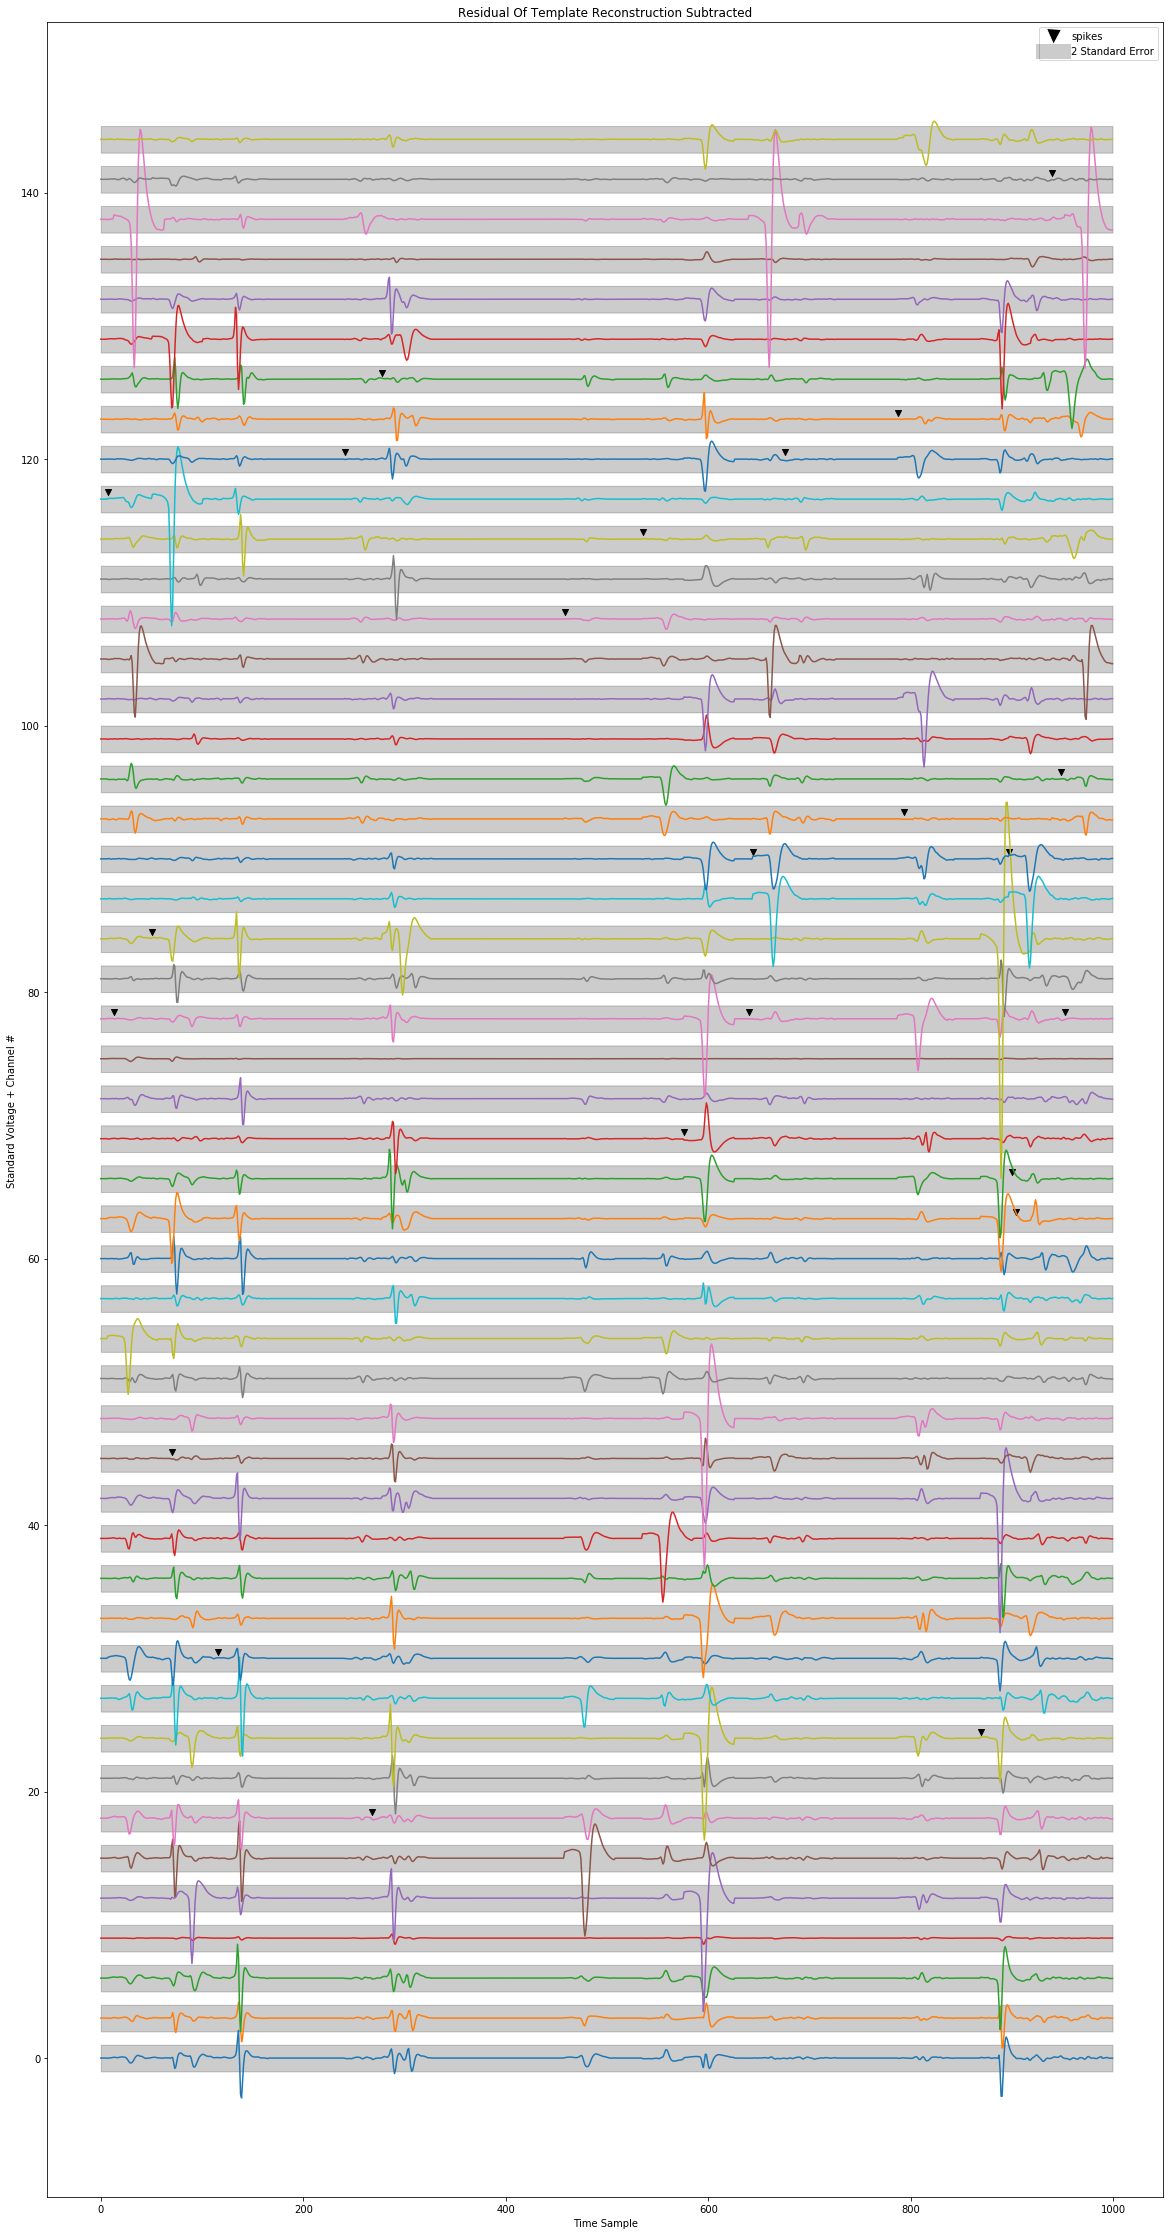

In [10]:
trunc_to = 1000
gold_sp_trunc = gold_sp[gold_sp[:, 0] < trunc_to, :]

fig, ax = plt.subplots()
for c in range(49):
    unit_sp = gold_sp_trunc[gold_sp_trunc[:, 1] == c, 0]
    offset = 3 * c
    ax.scatter(unit_sp, np.zeros(len(unit_sp)) + offset + 0.5, color='0', marker='v')
    ax.plot(data[:trunc_to, c] + offset)
    ax.fill_between(
        range(trunc_to),
        np.zeros(trunc_to) + offset + 1,
        np.zeros(trunc_to) + offset - 1, color='0', alpha=0.2)

legend_elements = [Line2D([0], [0], marker='v', color='w', label='spikes',
                          markerfacecolor='0', markersize=15),
                   Line2D([0], [0], lw=15, color='0', alpha=0.2, label='2 Standard Error')]
ax.legend(handles=legend_elements)

fig.set_size_inches(20, 40)
ax.set_xlabel("Time Sample")
ax.set_ylabel("Standard Voltage + Channel #")
if ALIGN:
    ax.set_title('Residual Of ALIGNED Template Reconstruction Subtracted')
    plt.savefig('data_residual_rank{}_aligned.pdf'.format(RANK))
else:
    ax.set_title('Residual Of Template Reconstruction Subtracted')
    plt.savefig('data_residual_rank{}.pdf'.format(RANK))

In [11]:
def conv_filter(data, temp, approx_rank=None, mode='full'):
    n_chan = temp.shape[1]
    conv_res = 0.
    if approx_rank is None or approx_rank > n_chan:
        for c in range(n_chan):
            conv_res += np.convolve(data[:, c], temp[:, c], mode)
    # Low rank approximation of convolution
    else:
        u, s, vh = np.linalg.svd(temp)
        for i in range(approx_rank):
            conv_res += np.convolve(
                np.matmul(data, vh[i, :].T),
                s[i] * u[:, i].flatten(), mode)
    return conv_res

In [12]:
main_channels(mwc_temps)

array([[25,  3, 22, ..., 23, 37, 45],
       [45, 25, 33, ..., 13, 17, 31],
       [25,  3, 45, ..., 40, 34, 48],
       ...,
       [25,  3, 45, ..., 44, 40, 48],
       [25,  3, 22, ..., 20, 38, 42],
       [ 3, 25, 41, ..., 18, 21, 10]])

In [13]:
class match_pursuit(object):

    def __init__(self, data, temps, obj_energy=True):
        self.n_time, self.n_chan, self.n_unit = temps.shape
        self.temps = temps
        self.data = data
        self.data_len = data.shape[0]
        self.temporal, self.singular, self.spatial = np.linalg.svd(
            np.transpose(np.flipud(temps), (2, 0, 1)))
        self.update_v_squared()
        self.obj_len = len(self.v_squared)
        self.dot = np.zeros([self.n_unit, self.obj_len])
        # compute norm of templates
        self.norm = np.zeros([self.n_unit, 1])
        for i in range(self.n_unit):
            self.norm[i] = np.sum(np.square(self.temps[:, :, i]))
        #
        self.obj_energy = obj_energy

    def update_v_squared(self):
        one_pad = np.ones([self.n_time, self.n_chan])
        self.v_squared = conv_filter(np.square(self.data), one_pad, approx_rank=3)

    def approx_conv_filter(self, unit, approx_rank=3):
        conv_res = 0.
        u, s, vh = self.temporal[unit], self.singular[unit], self.spatial[unit]
        for i in range(approx_rank):
            conv_res += np.convolve(
                np.matmul(self.data, vh[i, :].T),
                s[i] * u[:, i].flatten(), 'full')
        return conv_res

    def compute_objective(self):
        for i in range(self.n_unit):
            self.dot[i, :] = self.approx_conv_filter(i, approx_rank=3)
        self.obj = 2 * self.dot - self.norm
        if self.obj_energy:
            self.obj -= self.v_squared 
        return self.obj

    def find_peaks(self):
        refrac_period = self.n_time
        spike_times = scipy.signal.argrelmax(np.max(self.obj, 0), order=refrac_period)[0]
        spike_times = spike_times[spike_times < self.data_len - self.n_time]
        spike_ids = np.argmax(self.obj[:, spike_times], axis=0)
        return np.append(
            spike_times[:, np.newaxis] - self.n_time + 1,
            spike_ids[:, np.newaxis], axis=1)

    def subtract_spike_train(self, spt):
        for i in range(self.n_unit):
            unit_sp = spt[spt[:, 1] == i, :]
            self.data[np.arange(0, self.n_time) + unit_sp[:, :1], :] -= self.temps[:, :, i]
        self.update_v_squared()

    def run(self, n_iter=3):
        ctr = 0
        dec_spike_train = np.zeros([0, 2], dtype=np.int32)
        while ctr < n_iter:
            self.compute_objective()
            spt = self.find_peaks()
            print spt.shape
            self.subtract_spike_train(spt)
            dec_spike_train = np.append(dec_spike_train, spt, axis=0)
            ctr += 1
        return dec_spike_train

In [22]:
data1 = copy.copy(data)
mp = match_pursuit(data1, mwc_temps, obj_energy=False)

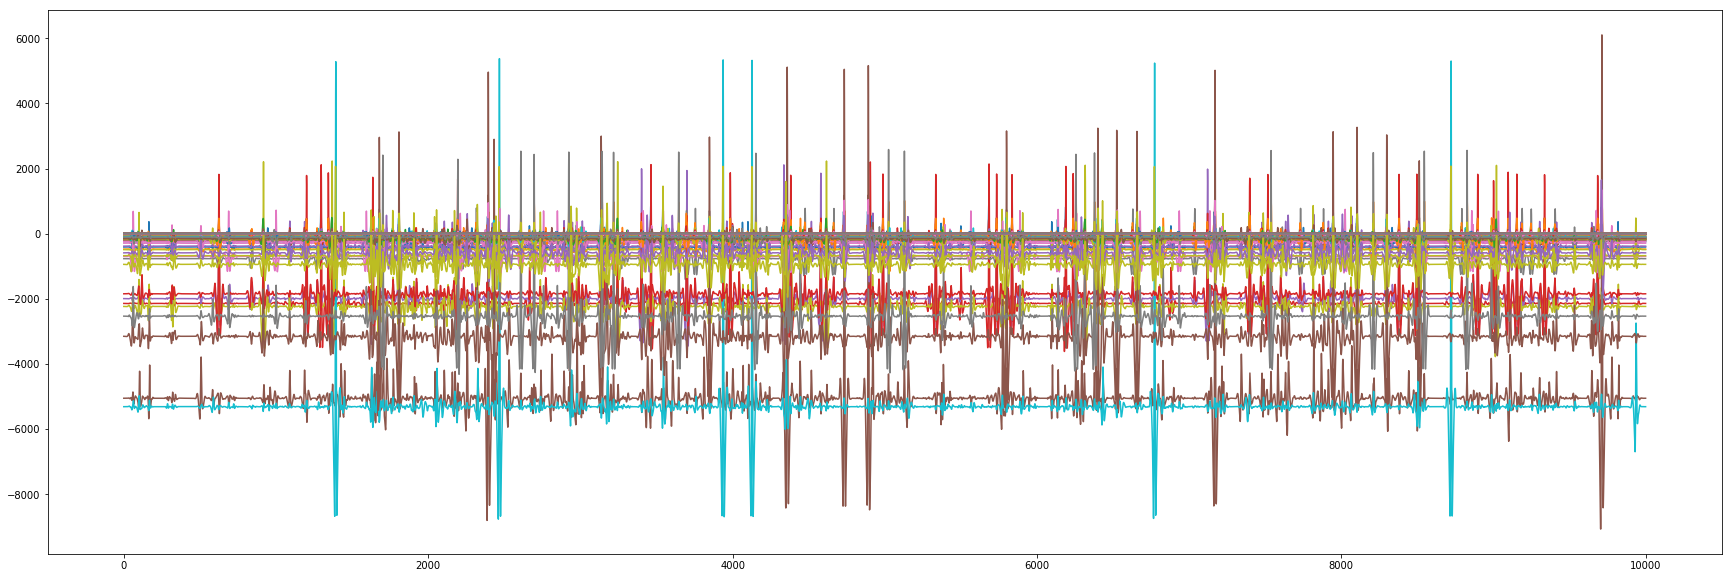

6208

In [15]:
o1 = mp.compute_objective()

fig, ax = plt.subplots()
vis_o = o1[:, 0:10000]
ax.plot(vis_o.T)
ax.plot(vis_o.T * 0)
fig.set_size_inches(30, 10)
plt.show()

np.argmax(vis_o[1, :]) - 49

In [23]:
deconvd_sp = mp.run(n_iter=10)
deconvd_sp[:, 0] += 25

(1842, 2)
(1608, 2)
(1301, 2)
(992, 2)
(673, 2)
(439, 2)
(266, 2)
(179, 2)
(134, 2)
(119, 2)


In [24]:
print gold_sp[gold_sp[:, 0] < 20000 * 10, :].shape
print deconvd_sp.shape

(7139, 2)
(7553, 2)


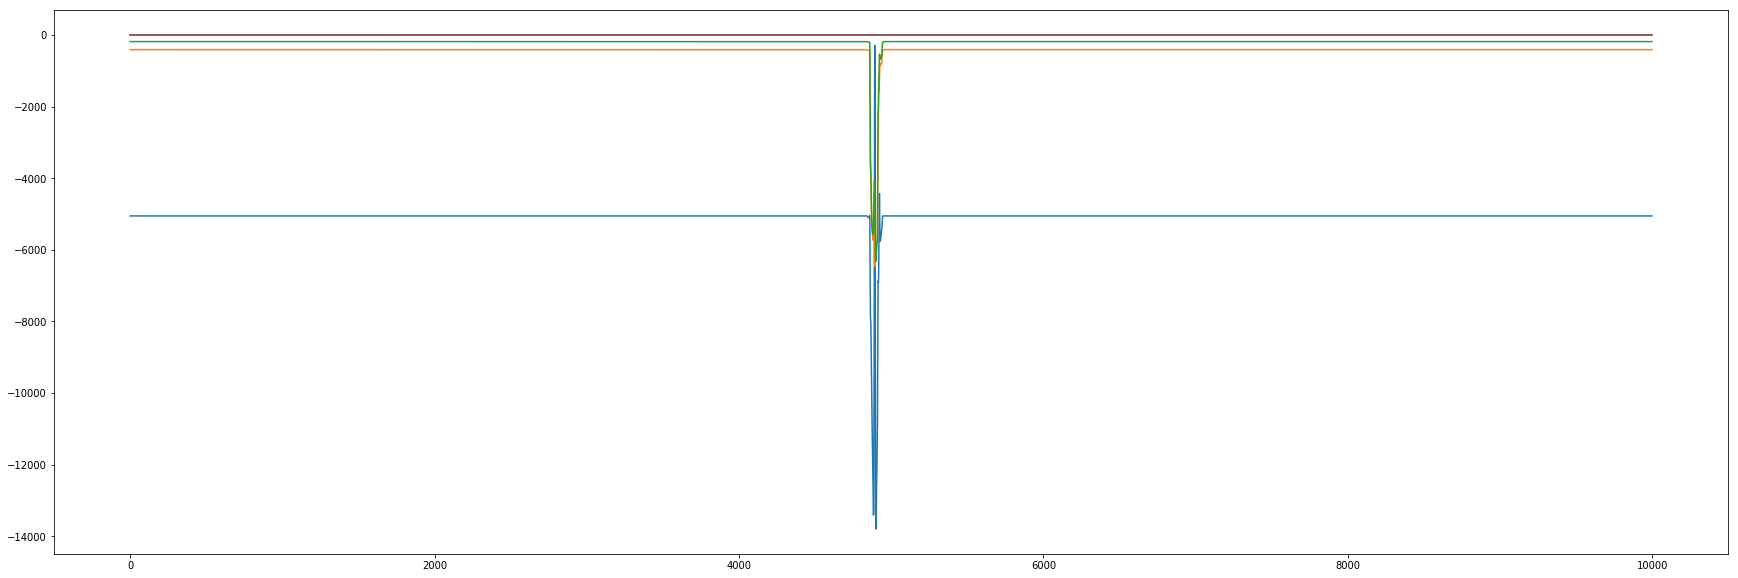

In [173]:
o1 = mp.compute_objective()

fig, ax = plt.subplots()
vis_o = o1[:, 0:10000]
ax.plot(vis_o.T)
ax.plot(vis_o.T * 0)
fig.set_size_inches(30, 10)
plt.show()

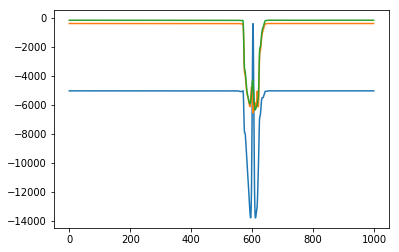

In [174]:
plt.plot(o1[:, 69000:70000].T)

In [25]:
def plot_chan_numbers(geom, ax, offset=10):
    """Plots template spatially.77"""
    for c in range(geom.shape[0]):
        plt.text(geom[c, 0] + offset, geom[c, 1], str(c), size='large')

geom_m = parse(os.path.join(base_dir, geom), 49)
m_c = main_channels(mwc_temps)[:, -1]
temps = mwc_temps

In [26]:
print 'unit\trecovered\toriginal\tdiff\tmain_channel'
gold_sp_trunc = gold_sp[gold_sp[:, 0] < TOT_TIME, :]
diffs = []
for unit in np.unique(gold_sp_trunc[:, 1]):
    sp = deconvd_sp[deconvd_sp[:, 1] == unit, 0]
    diffs.append(np.sum(gold_sp_trunc[:, 1] == unit) - len(sp))
    print '{}\t{}\t\t{}\t\t{}\t\t{}'.format(
        unit, len(sp), np.sum(gold_sp_trunc[:, 1] == unit), diffs[-1], m_c[unit])


unit	recovered	original	diff	main_channel
0	58		58		0		45
1	72		71		-1		31
2	42		42		0		48
3	121		121		0		37
4	65		65		0		11
5	68		68		0		9
6	72		72		0		22
7	132		132		0		48
8	100		101		1		28
9	105		105		0		47
10	86		86		0		9
11	31		32		1		45
12	52		52		0		33
13	67		67		0		37
14	99		100		1		15
15	93		93		0		4
16	38		38		0		42
17	45		45		0		10
18	51		51		0		47
19	125		125		0		21
20	126		126		0		39
21	107		106		-1		21
22	852		435		-417		45
23	322		322		0		16
24	313		313		0		19
25	242		242		0		10
26	333		333		0		46
27	412		412		0		31
28	393		394		1		39
29	309		309		0		44
30	211		211		0		29
31	140		140		0		34
32	226		227		1		41
33	125		125		0		12
34	15		15		0		42
35	101		101		0		9
36	294		294		0		5
37	105		106		1		24
38	152		152		0		13
39	167		167		0		18
40	78		76		-2		46
41	133		133		0		26
42	233		233		0		28
43	54		54		0		48
44	162		162		0		0
45	175		175		0		43
46	160		161		1		48
47	44		44		0		42
48	47		47		0		10


In [27]:
all_units = np.unique(gold_sp_trunc[:, 1])
bad_units = np.where(np.abs(diffs) > 5)[0]

In [32]:
sp = deconvd_sp[deconvd_sp[:, 1] == unit, 0]
sp = sp[:, np.newaxis] + np.arange(-25, 25, 1)
data[:, :][sp].shape

(47, 50, 49)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


/home/hooshmand/Documents/github/yassenv/local/lib/python2.7/site-packages/matplotlib/pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48


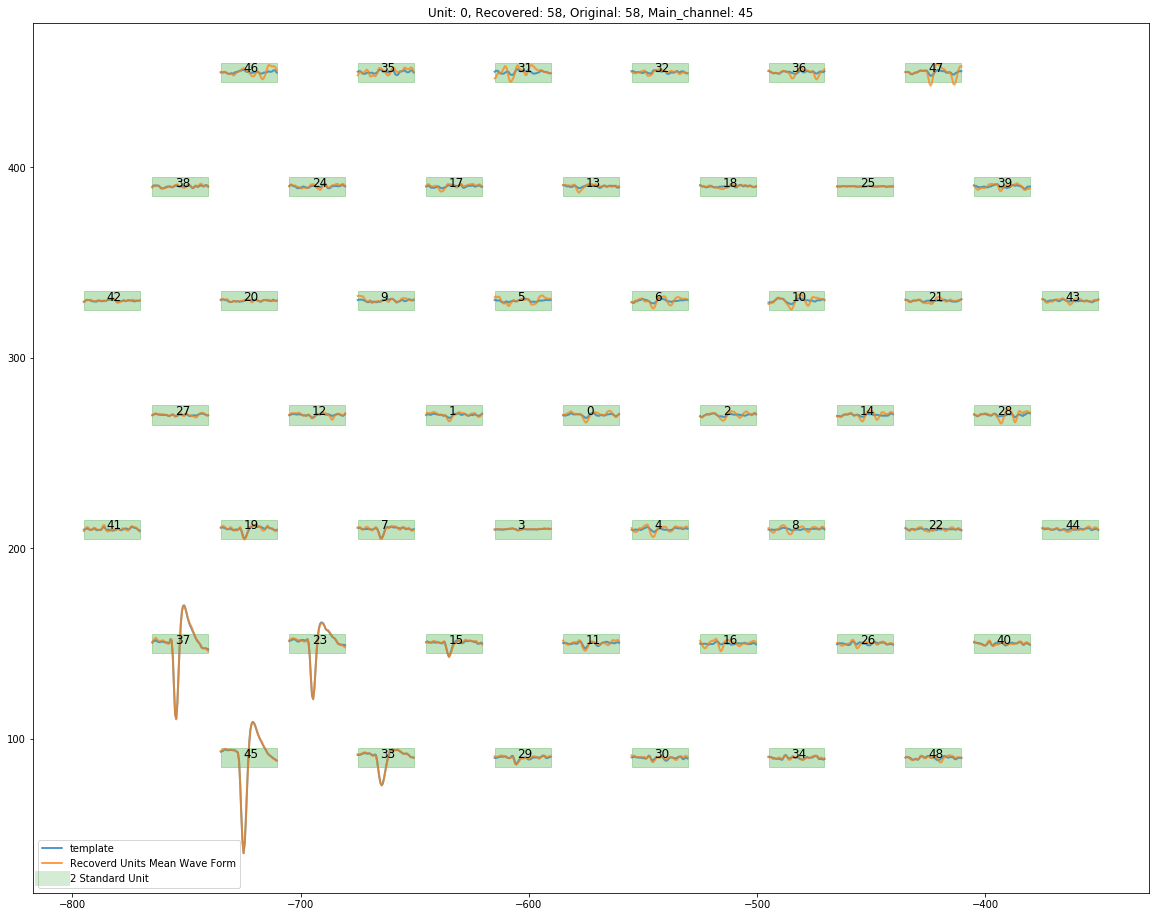

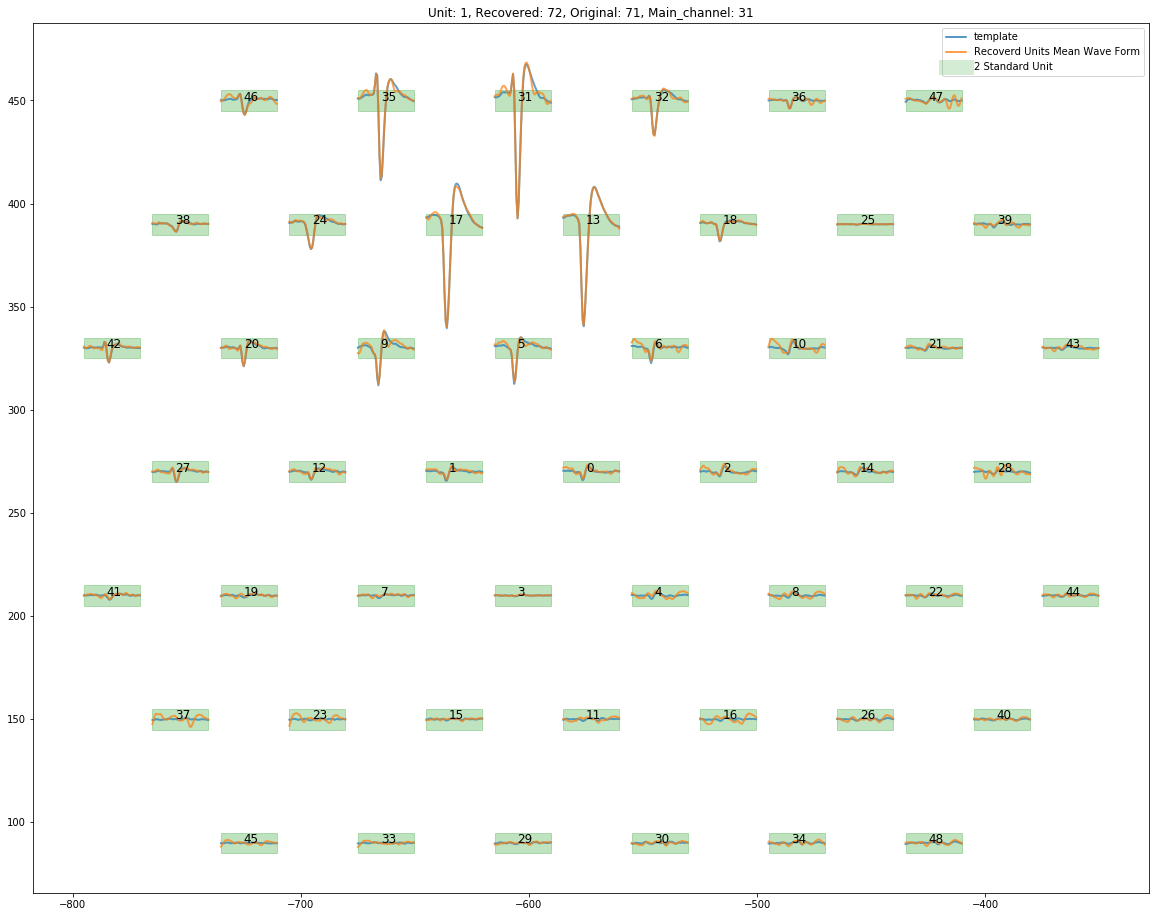

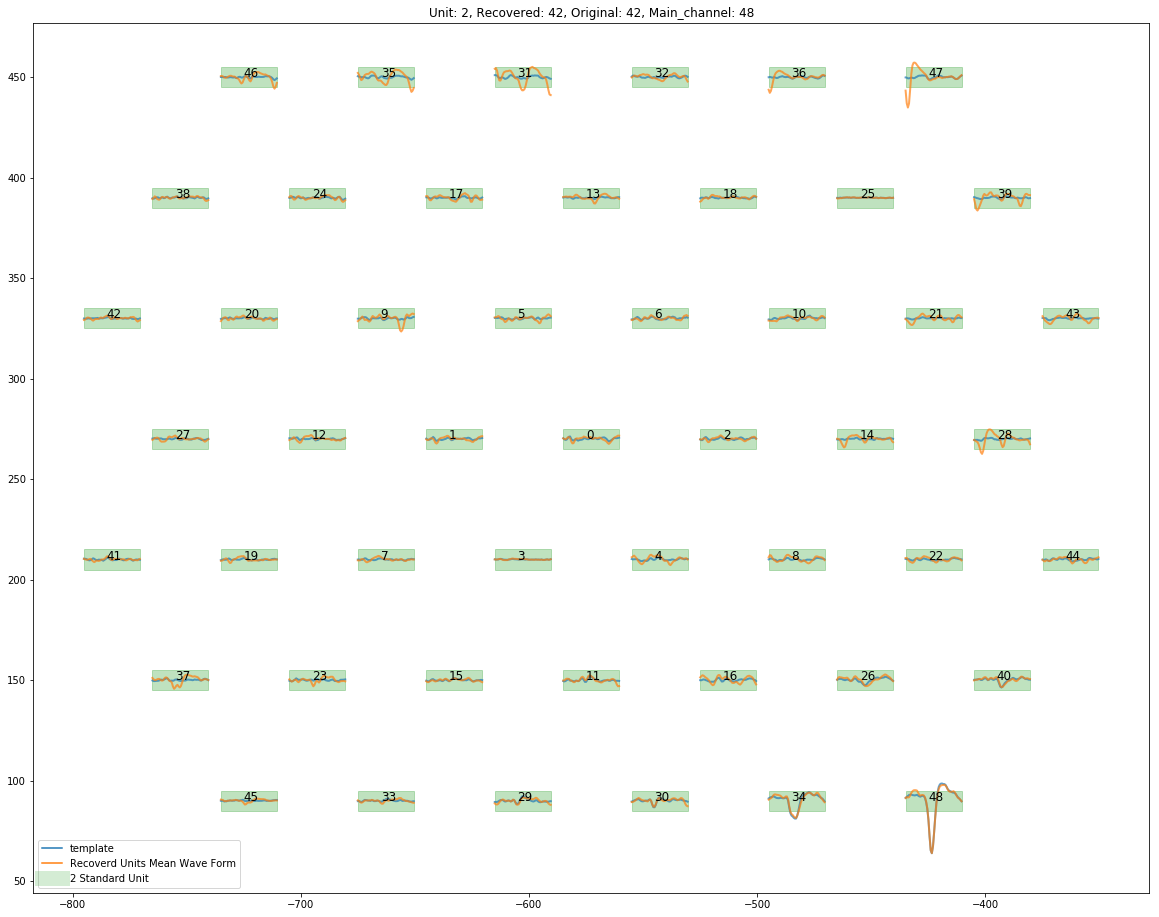

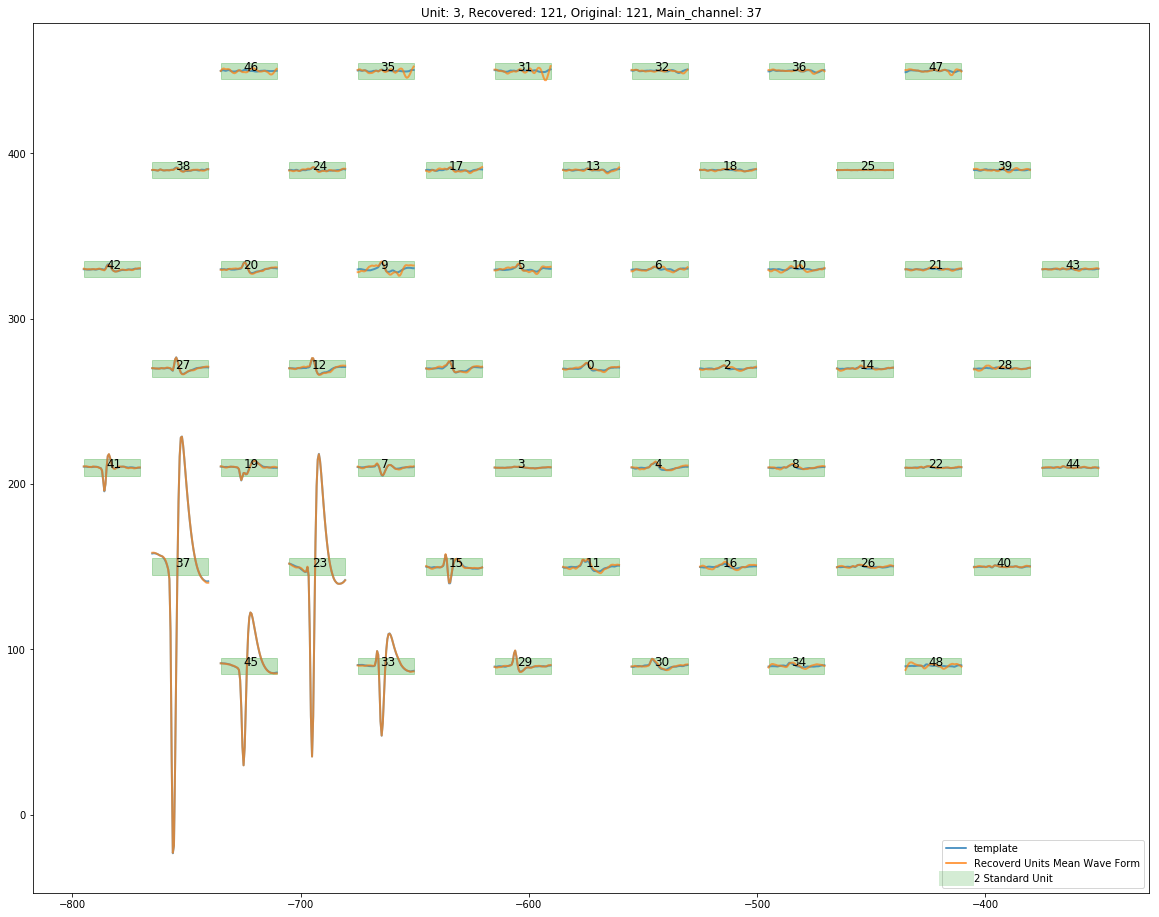

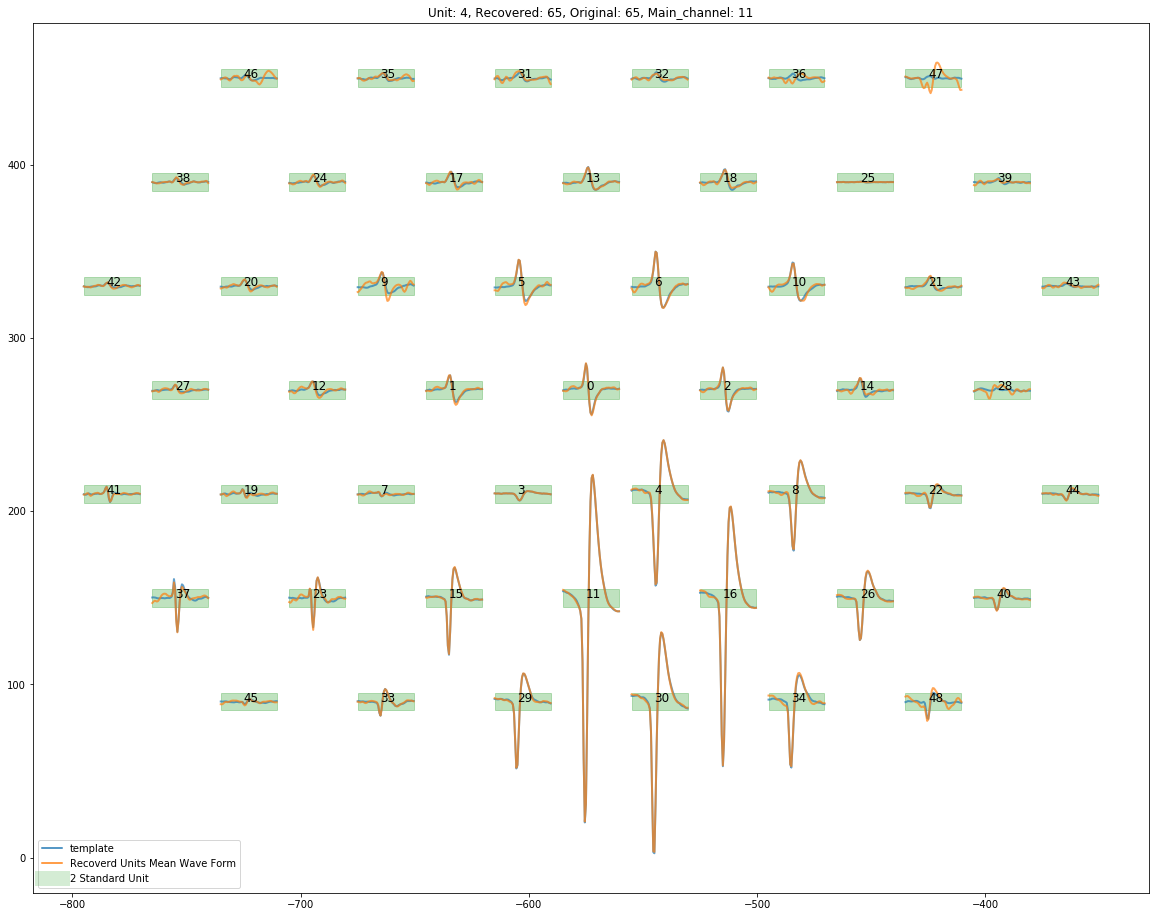

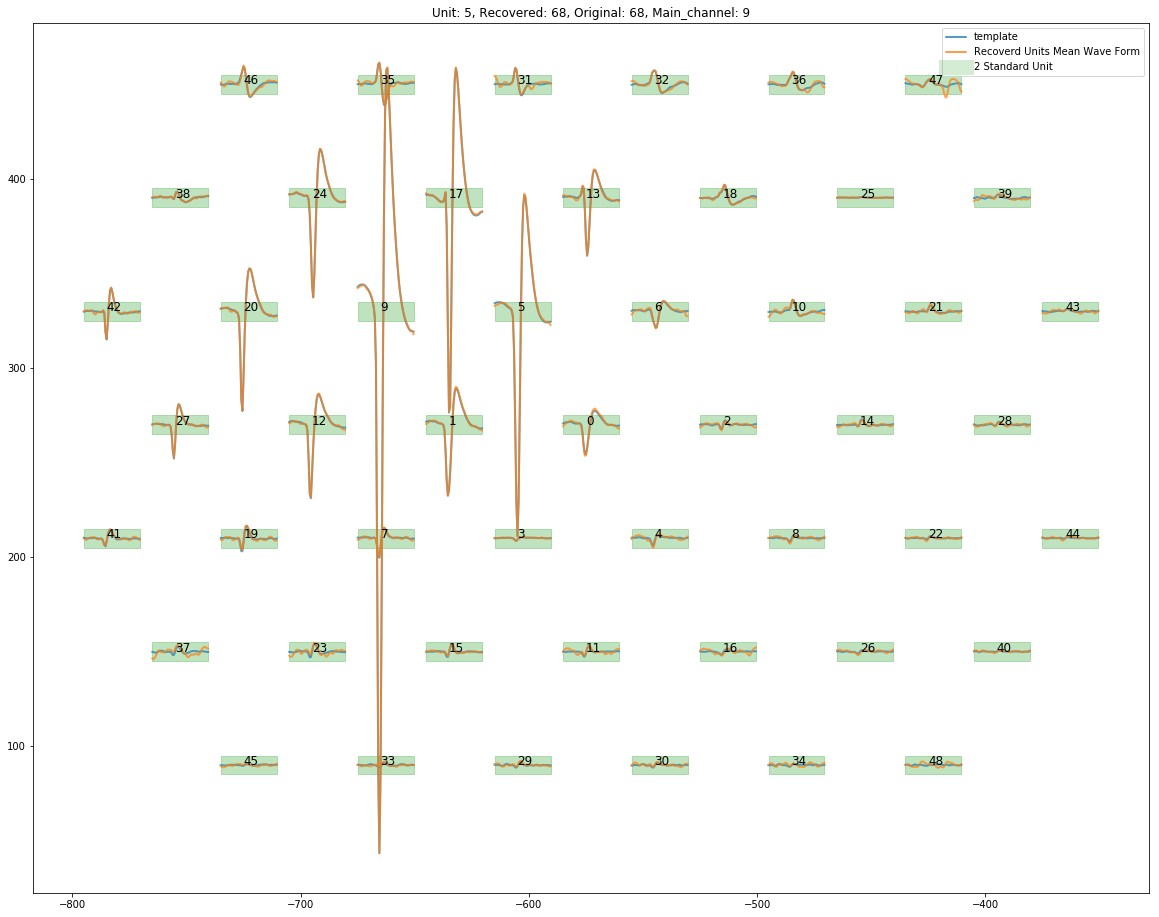

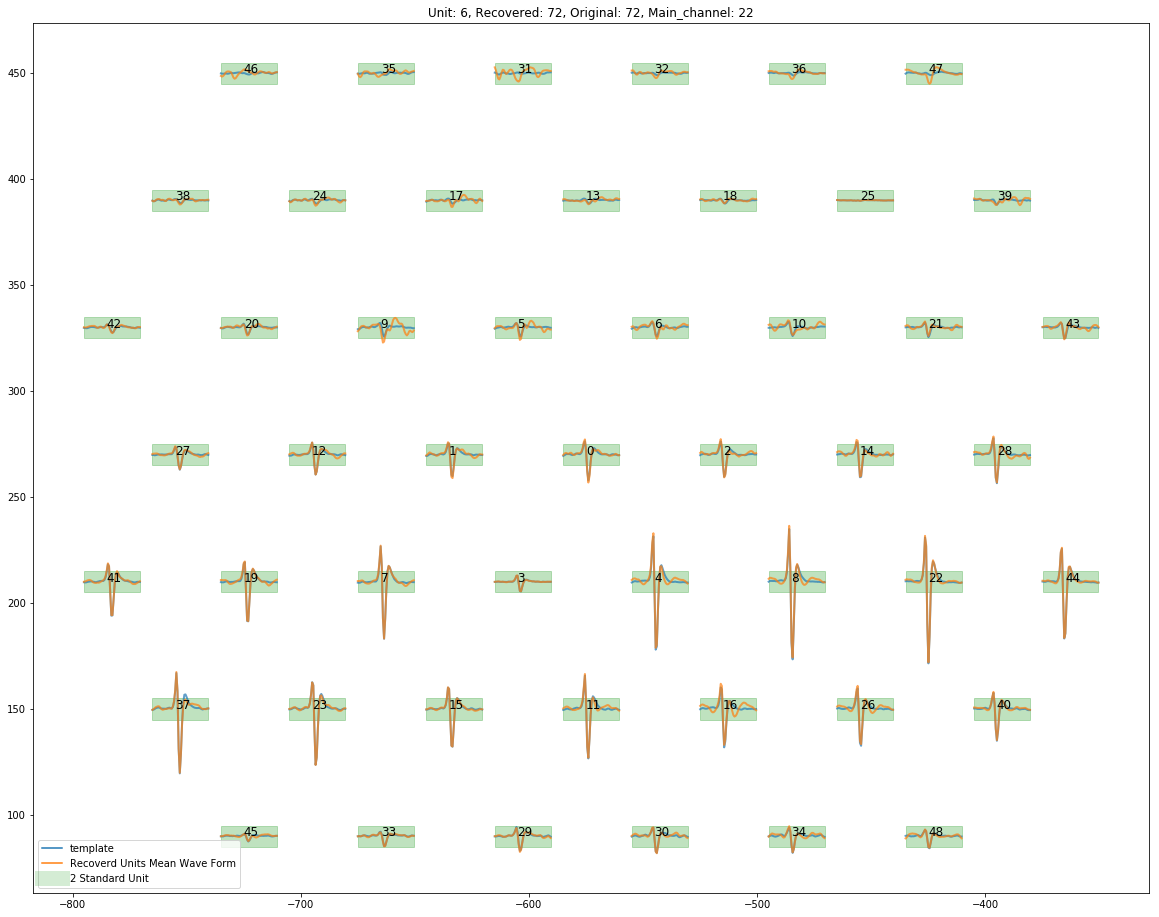

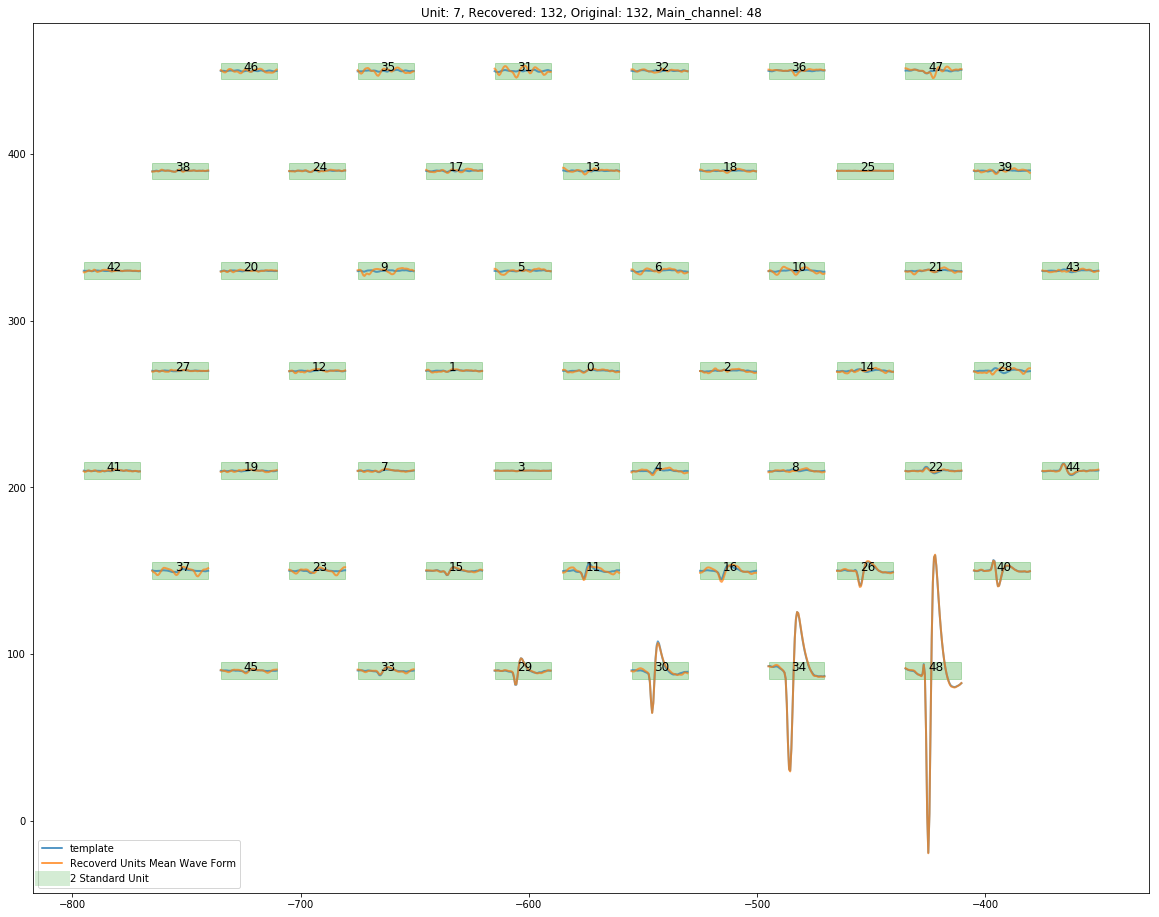

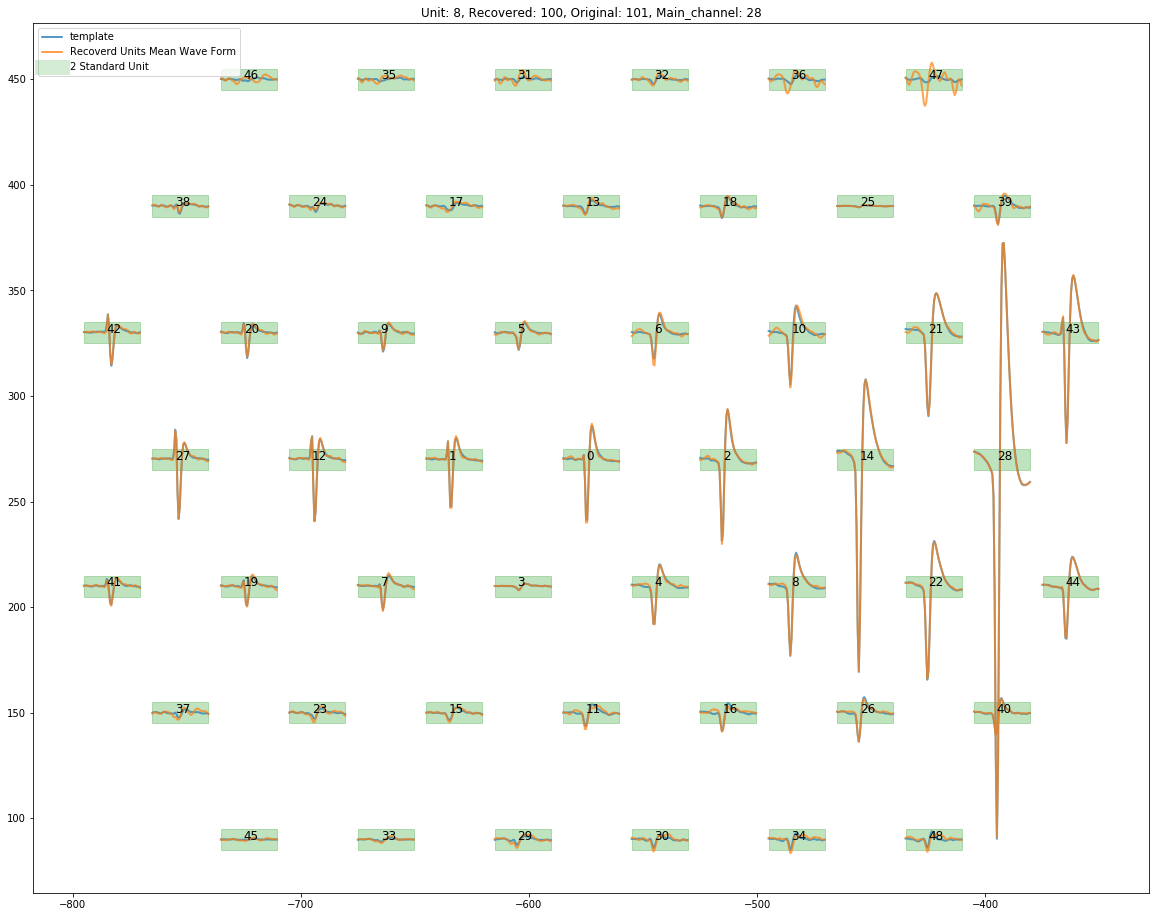

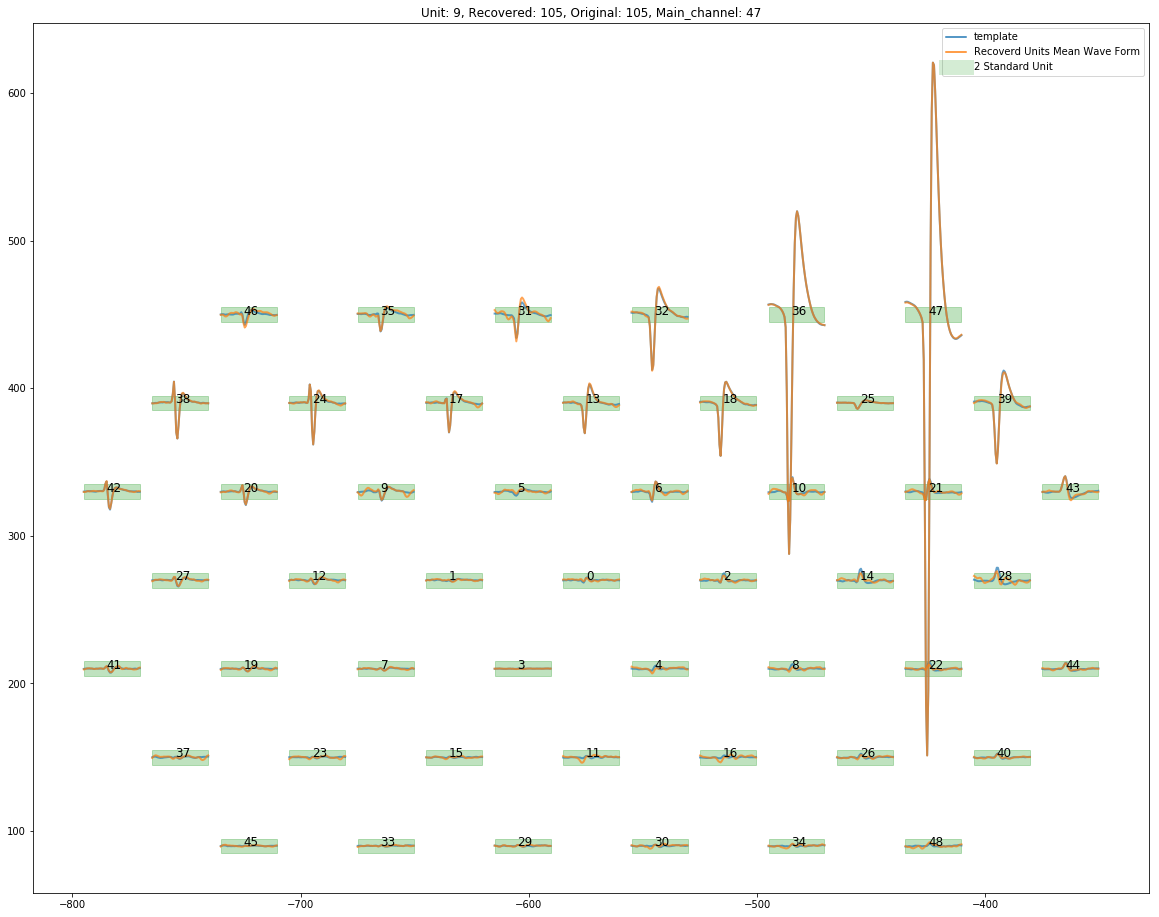

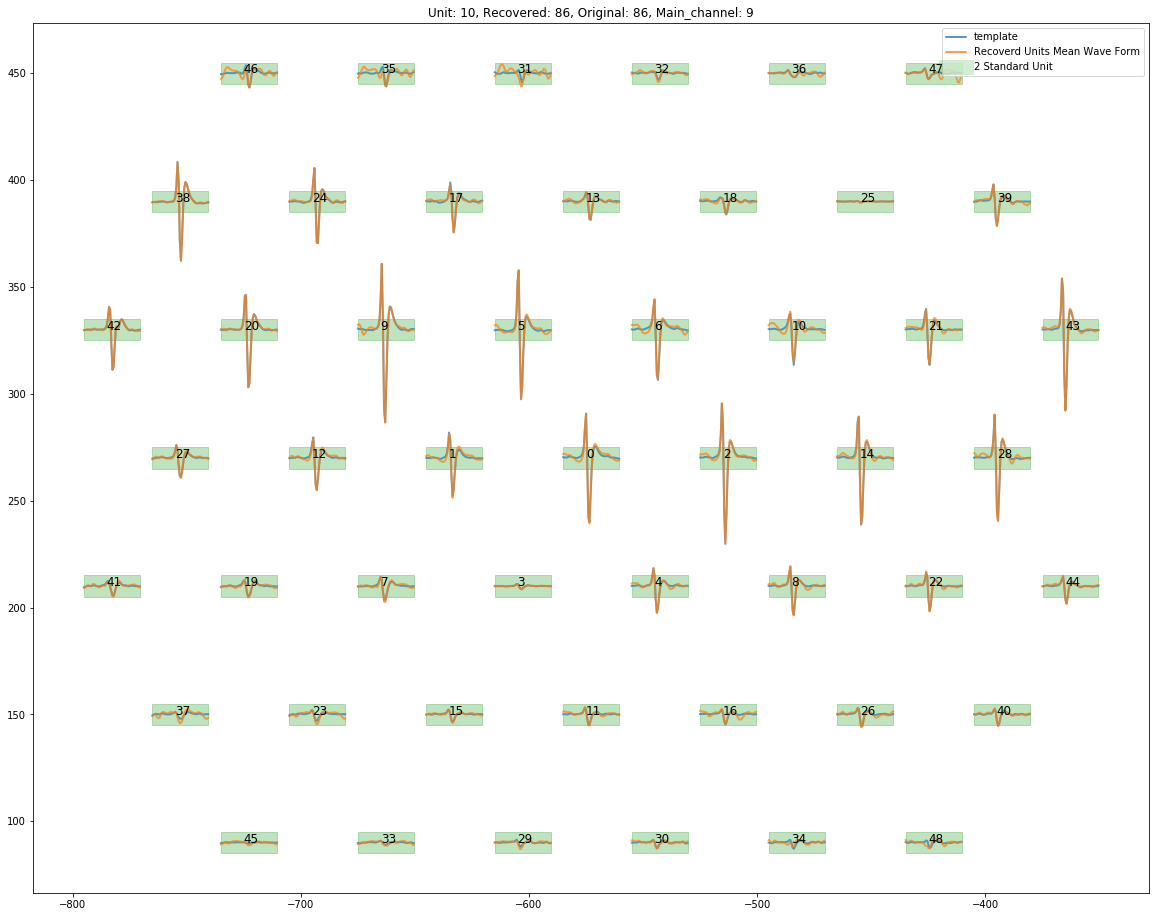

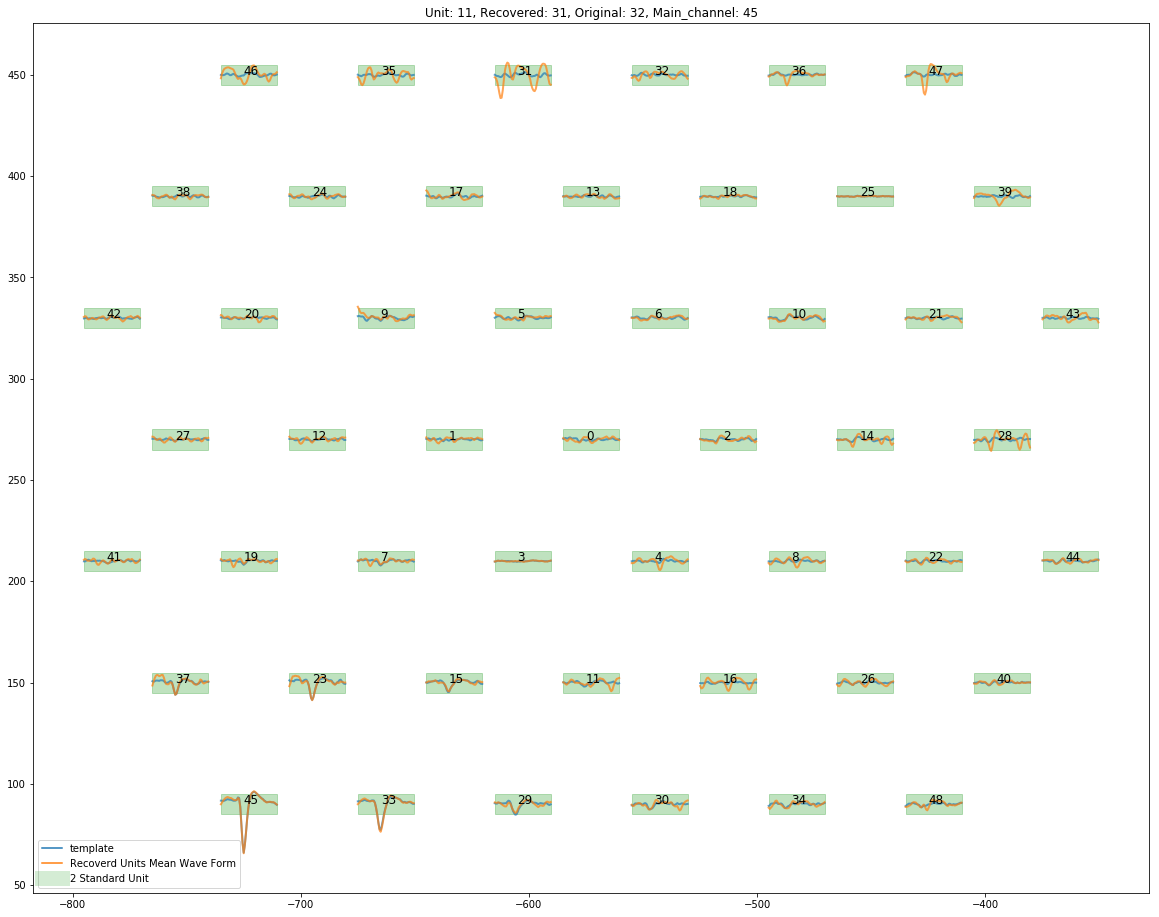

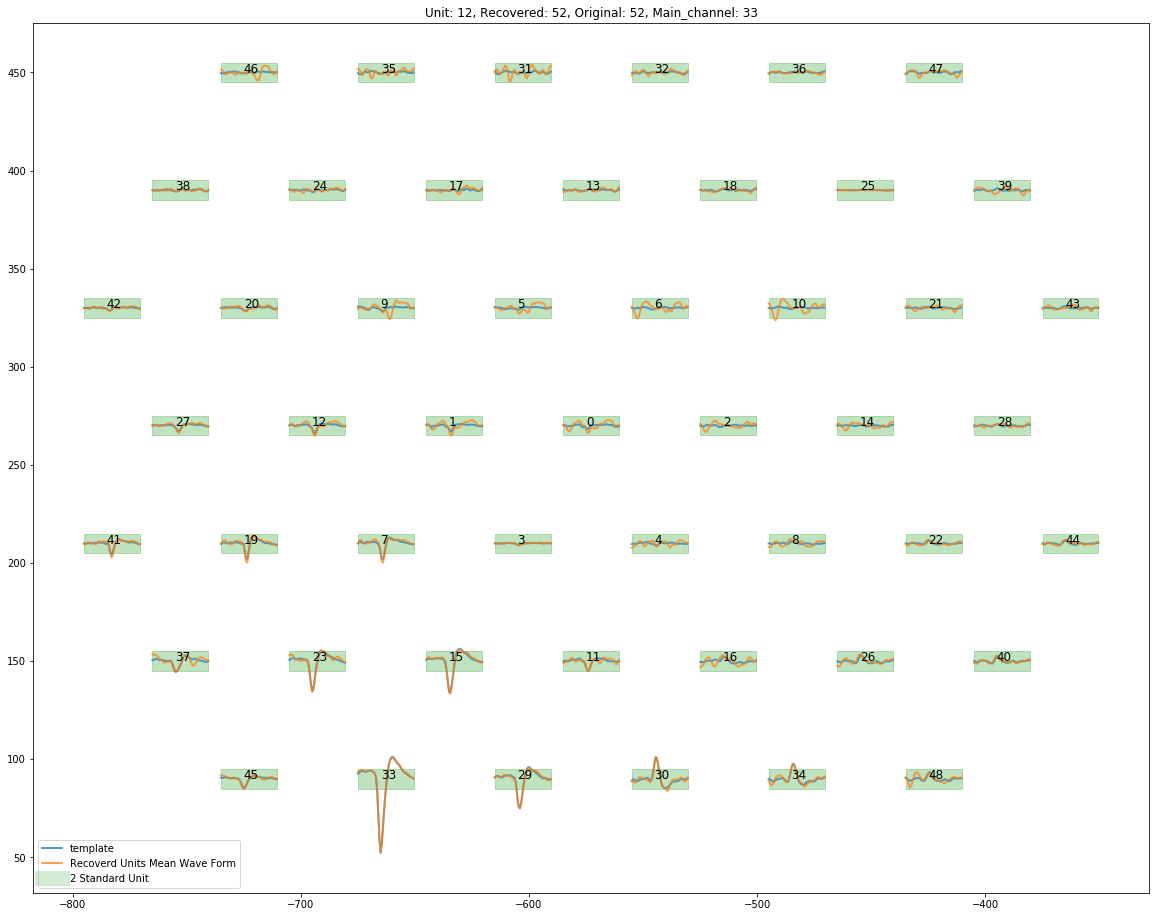

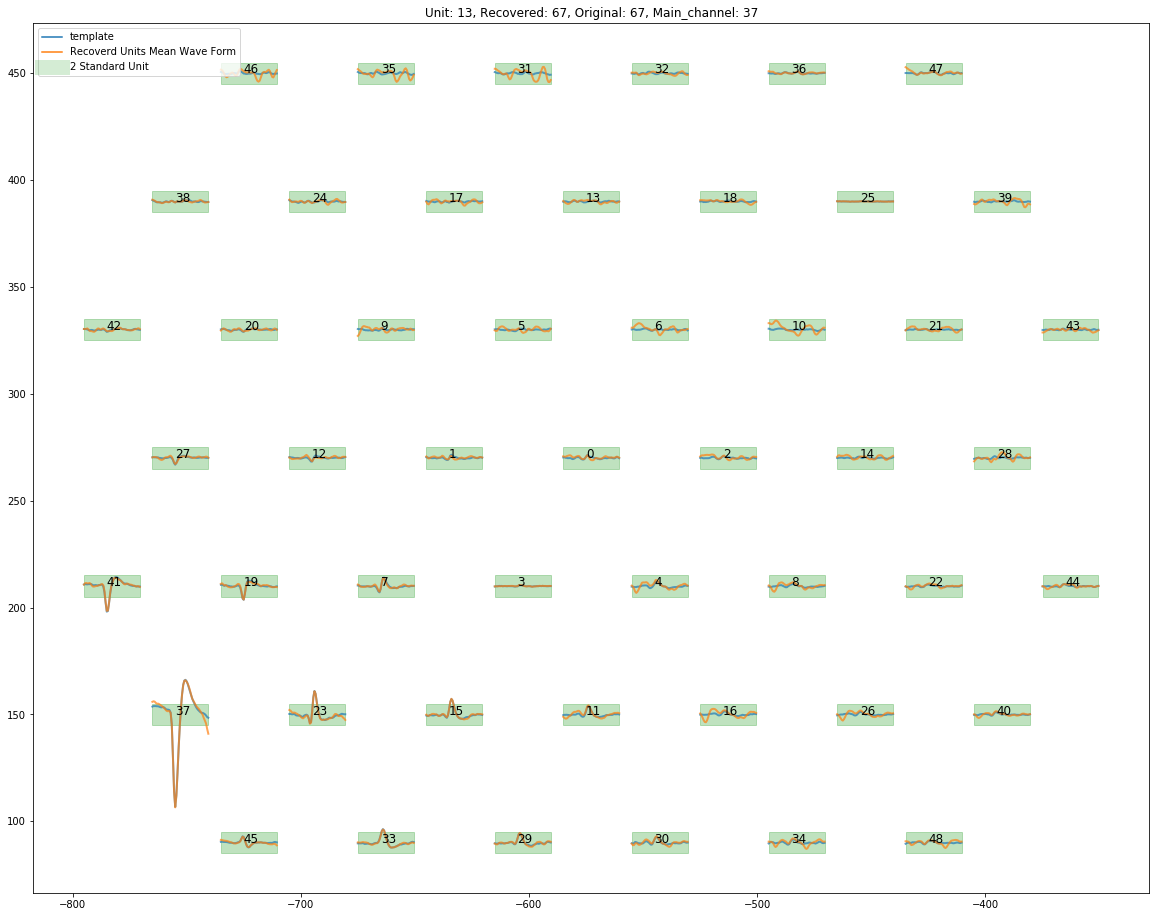

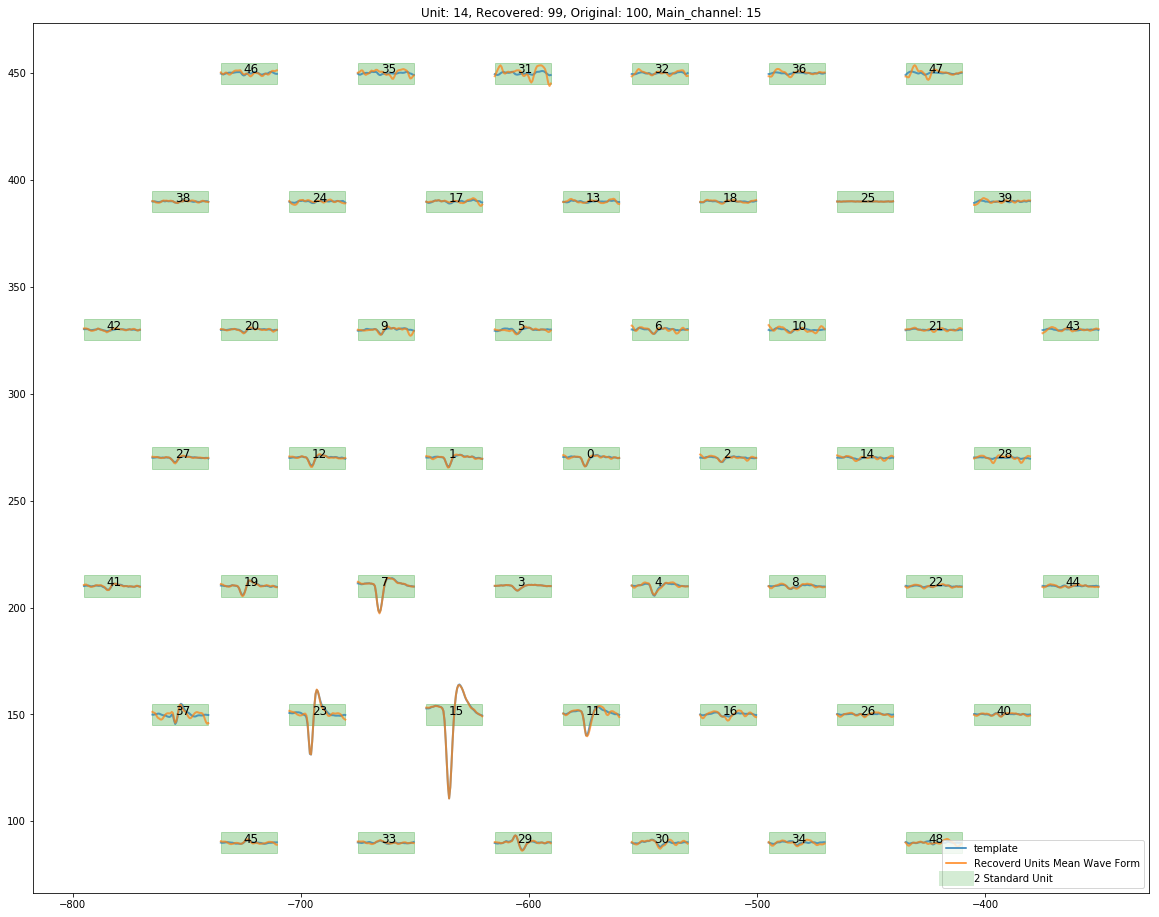

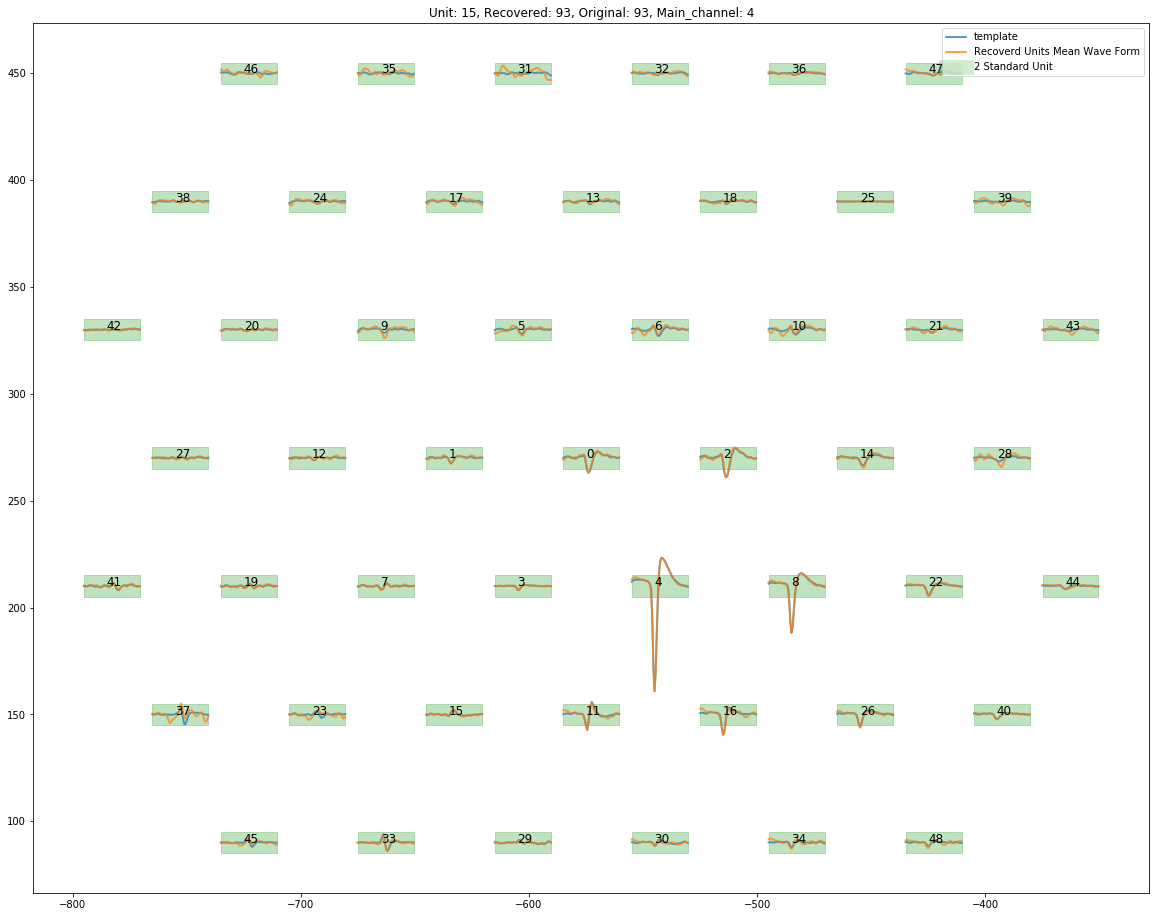

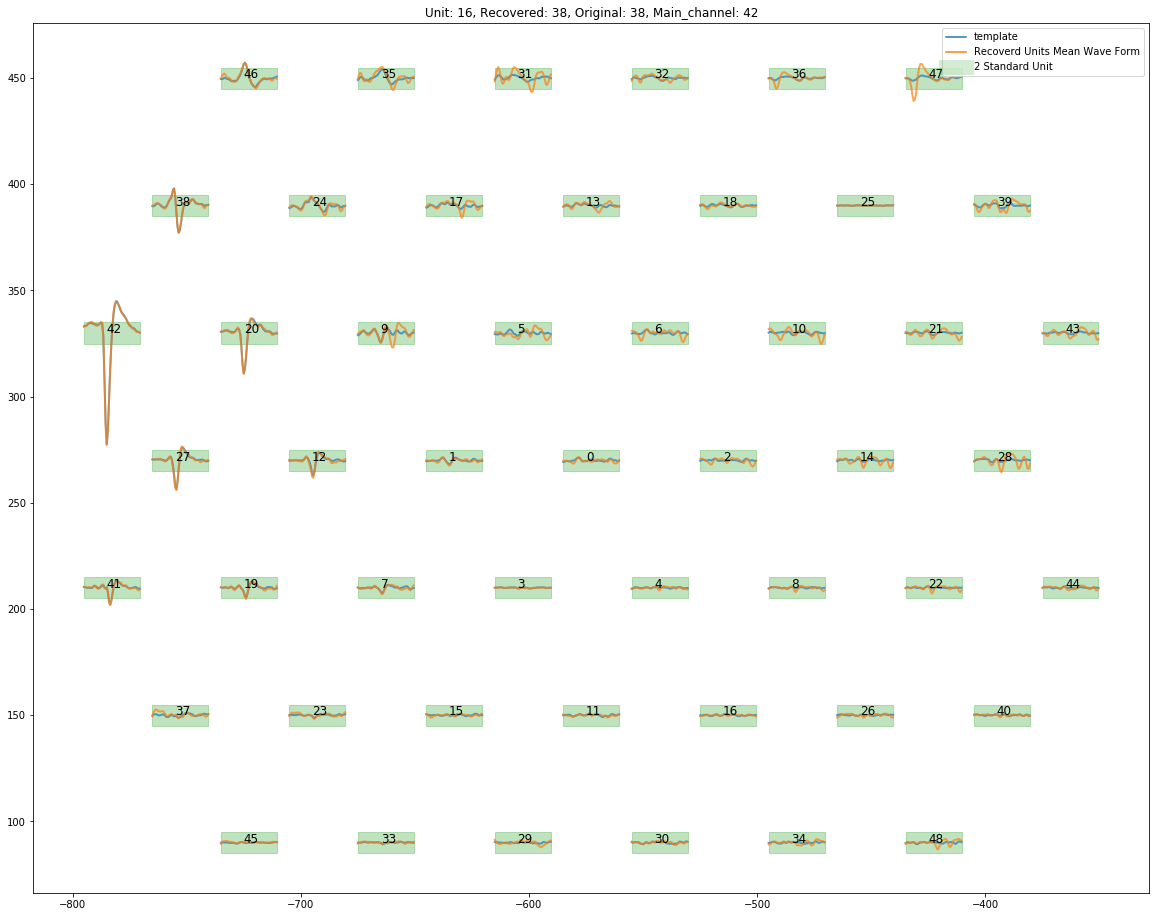

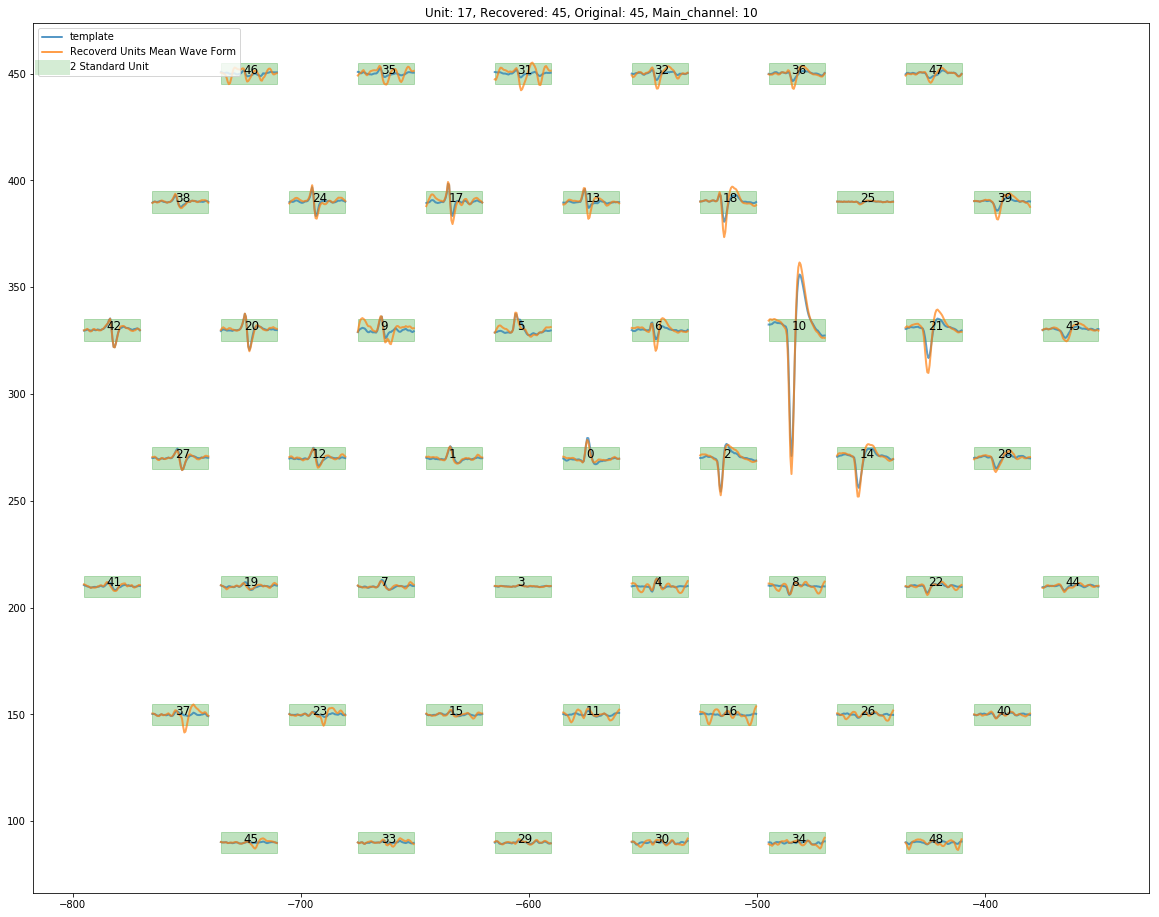

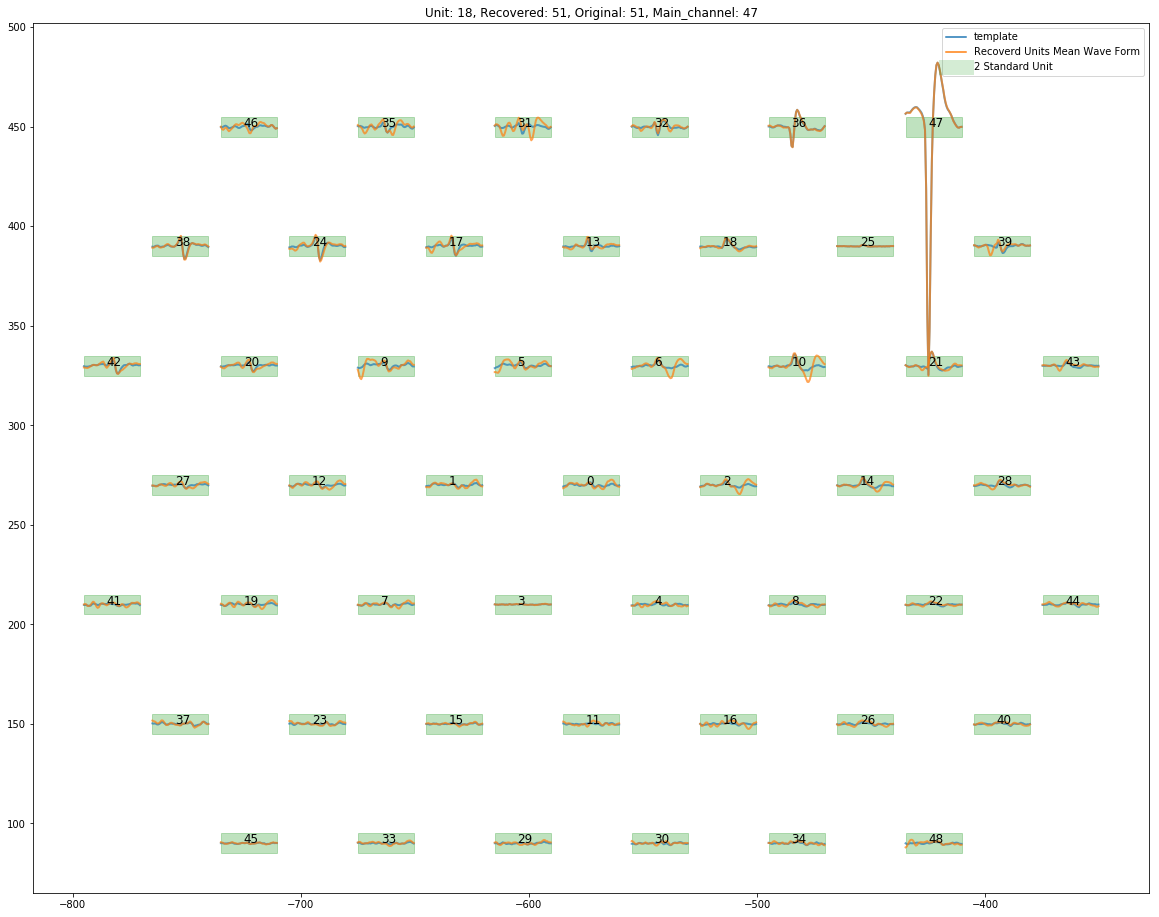

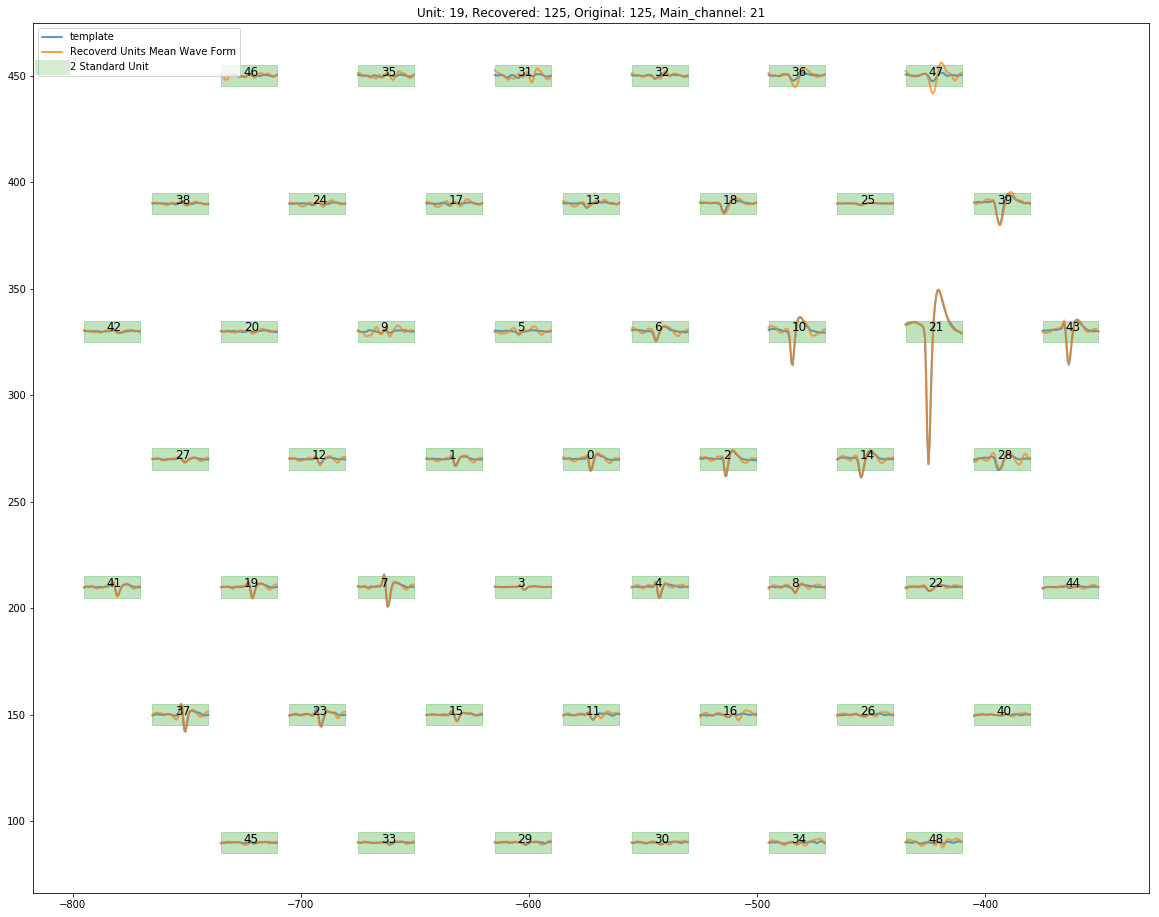

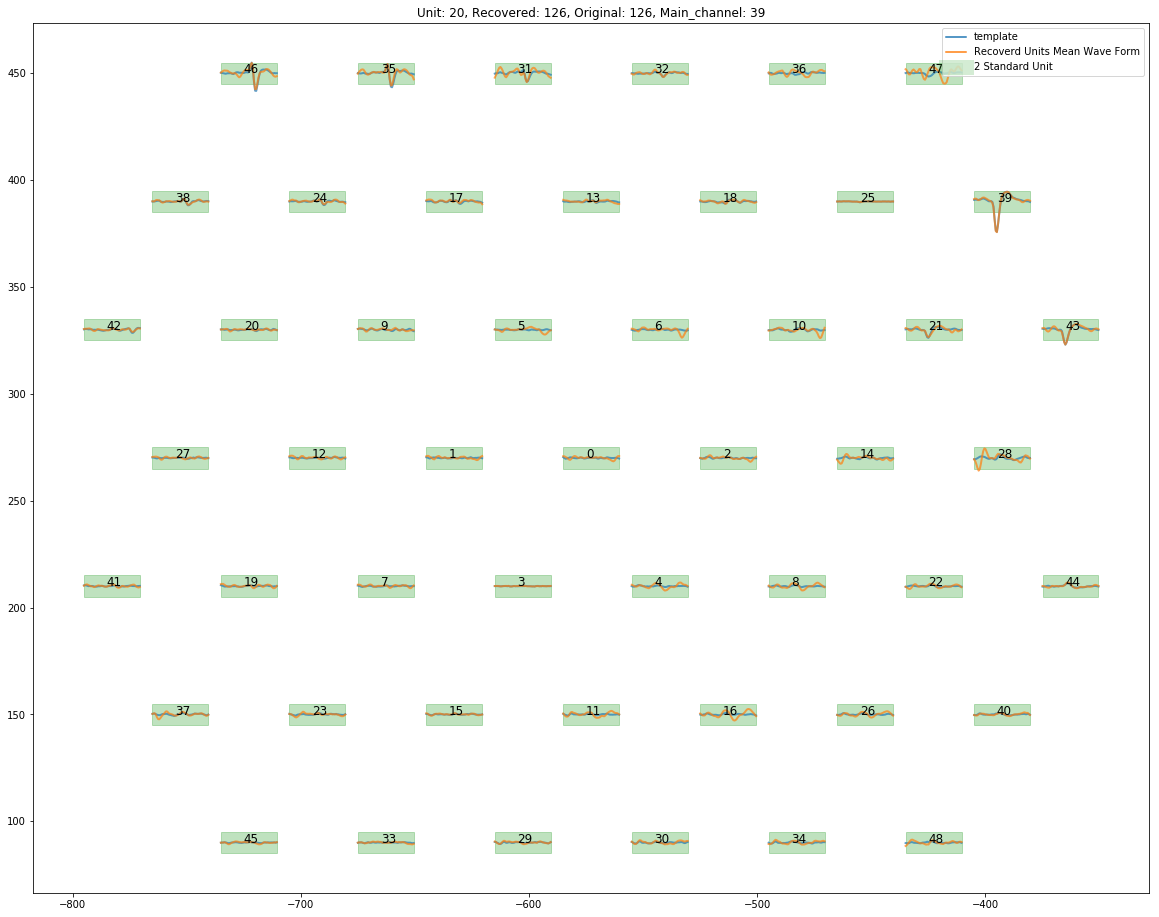

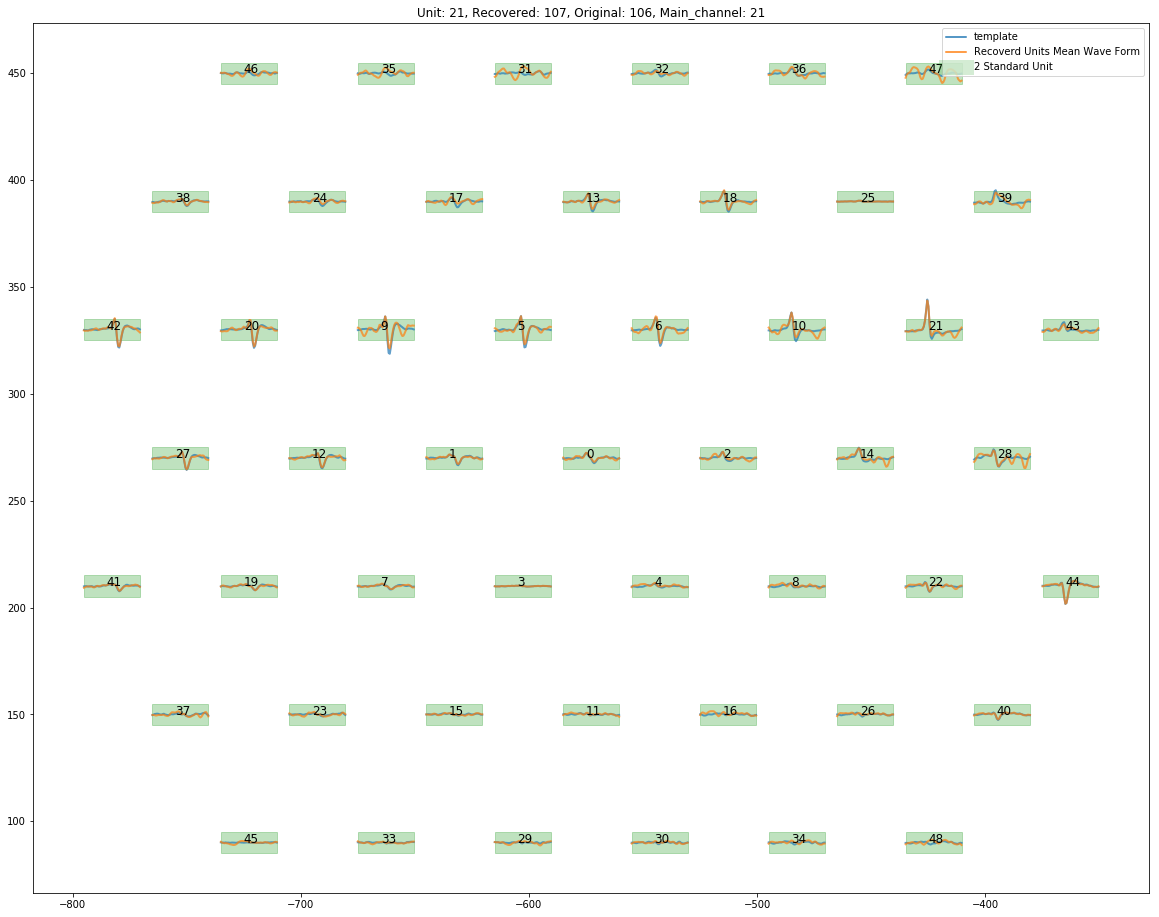

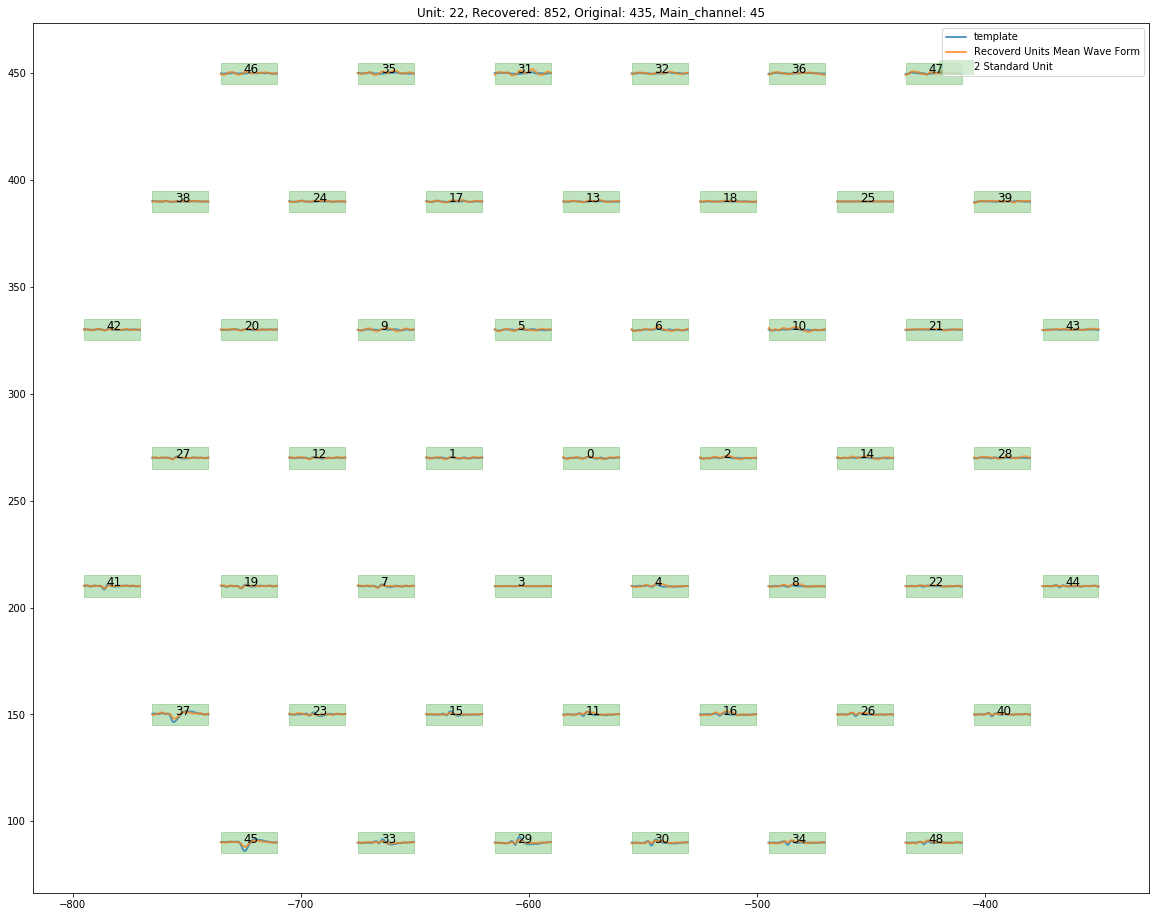

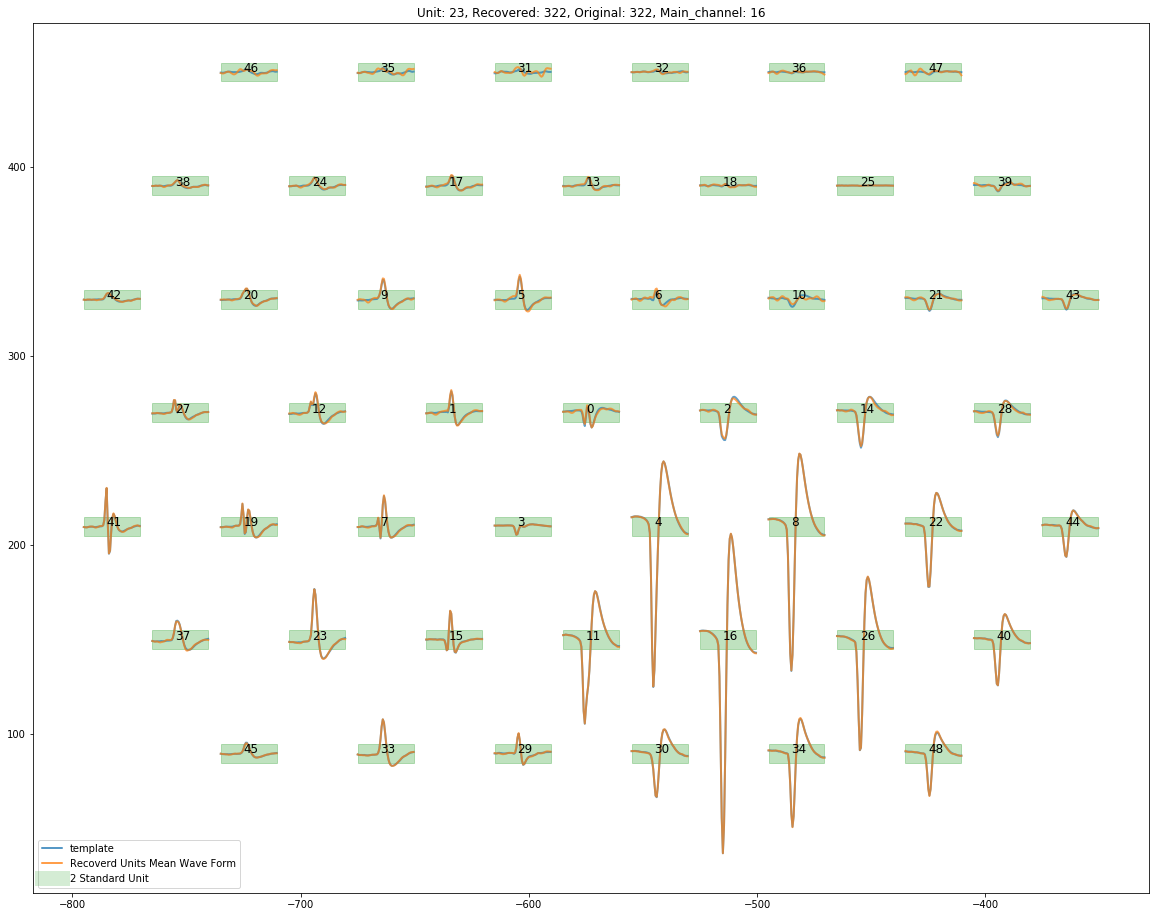

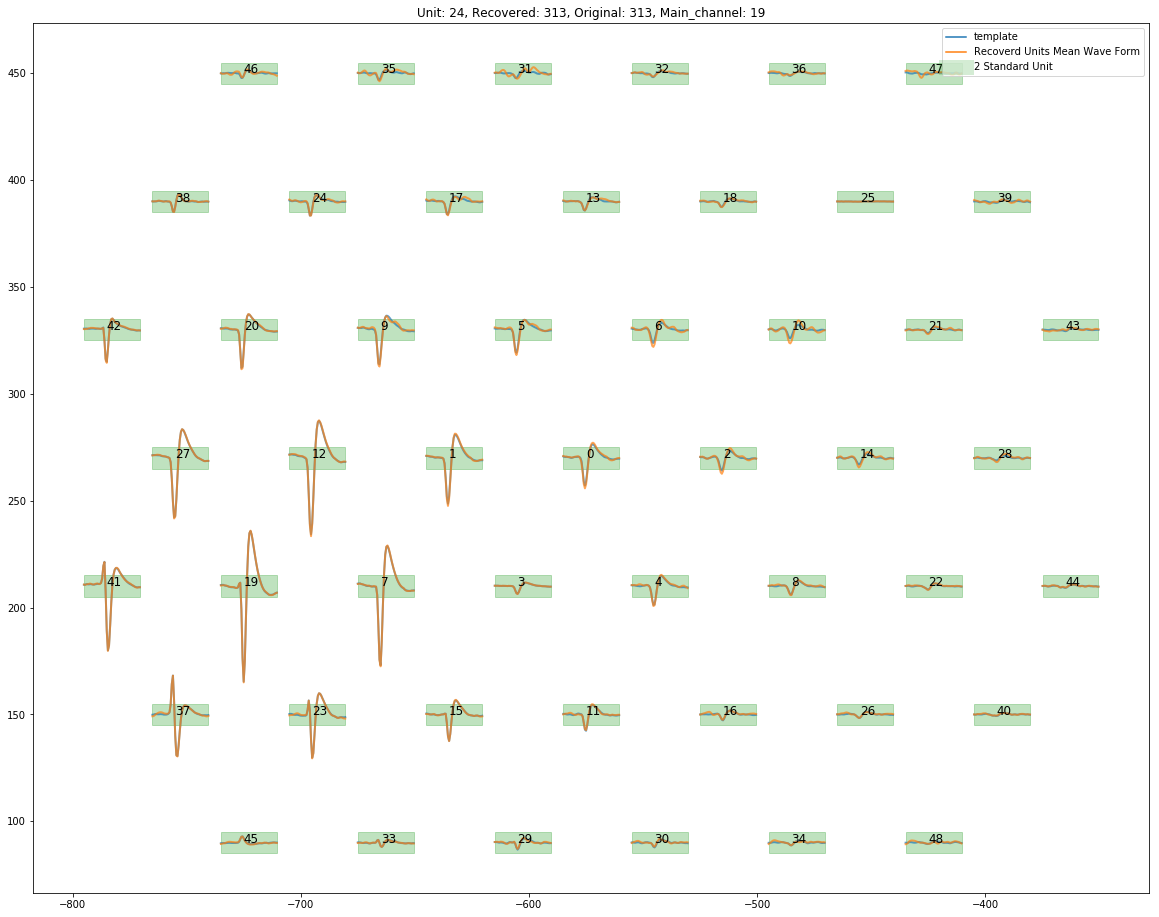

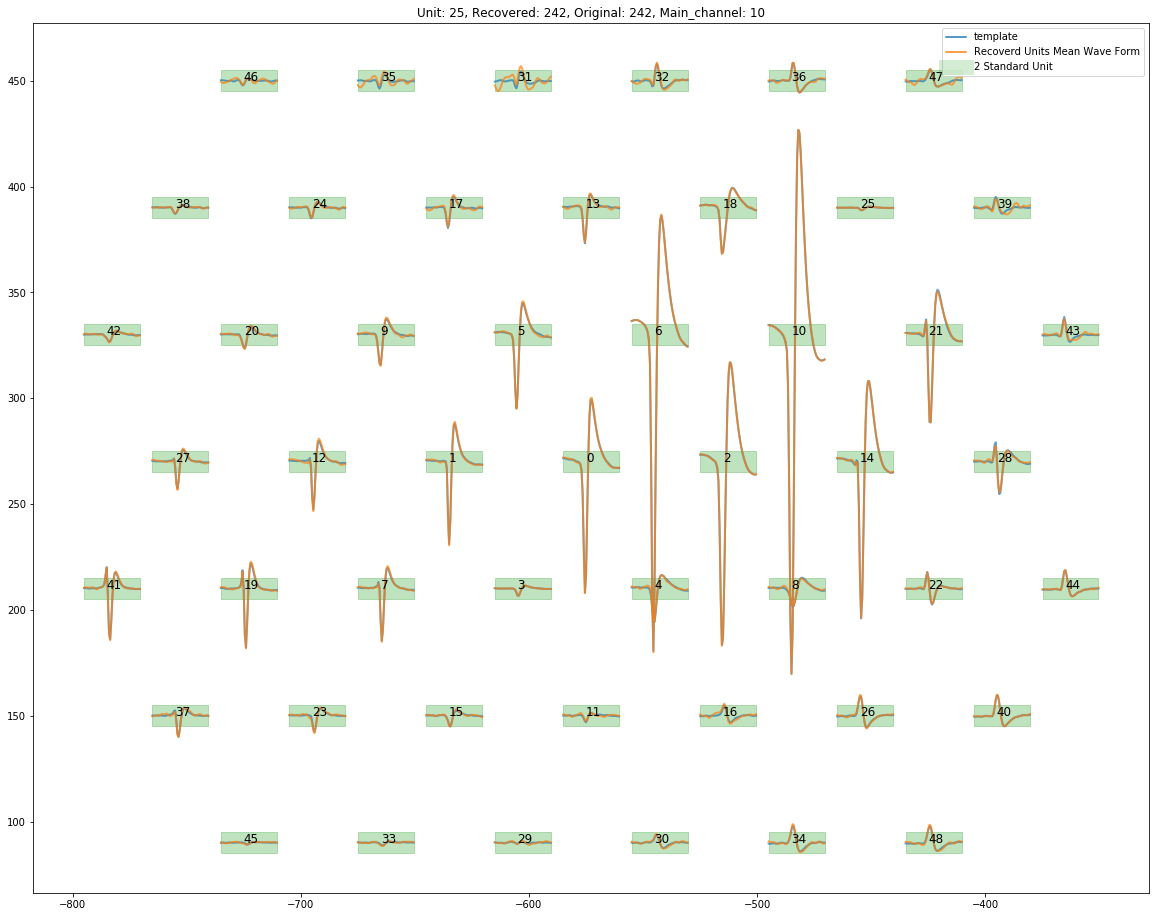

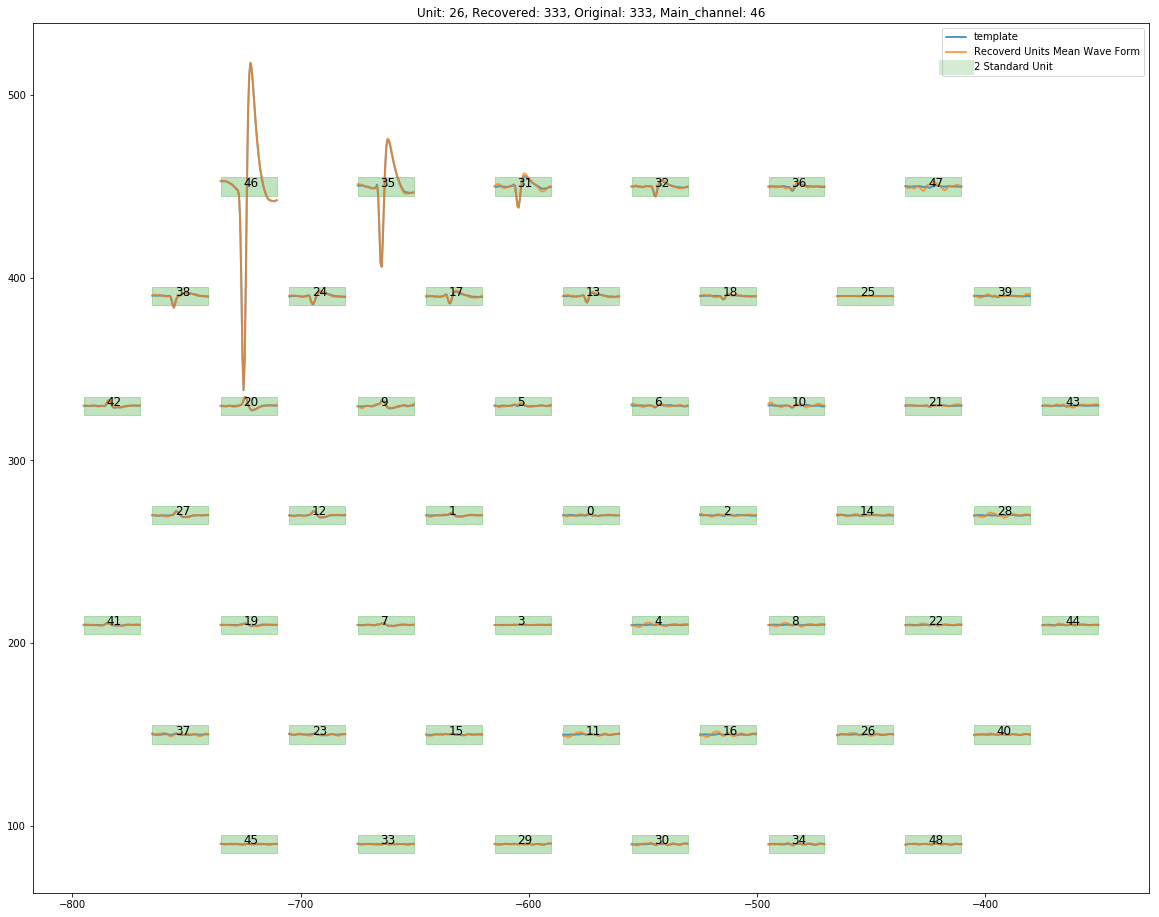

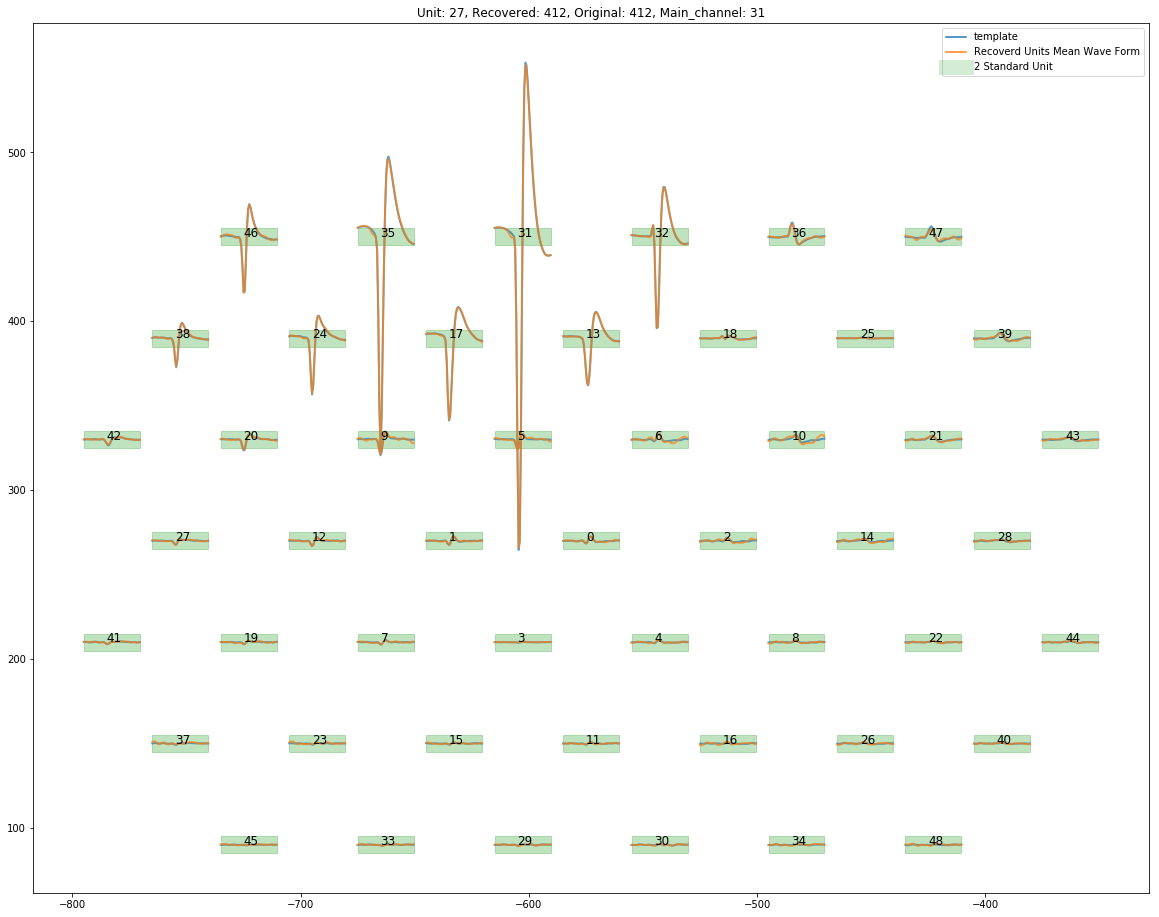

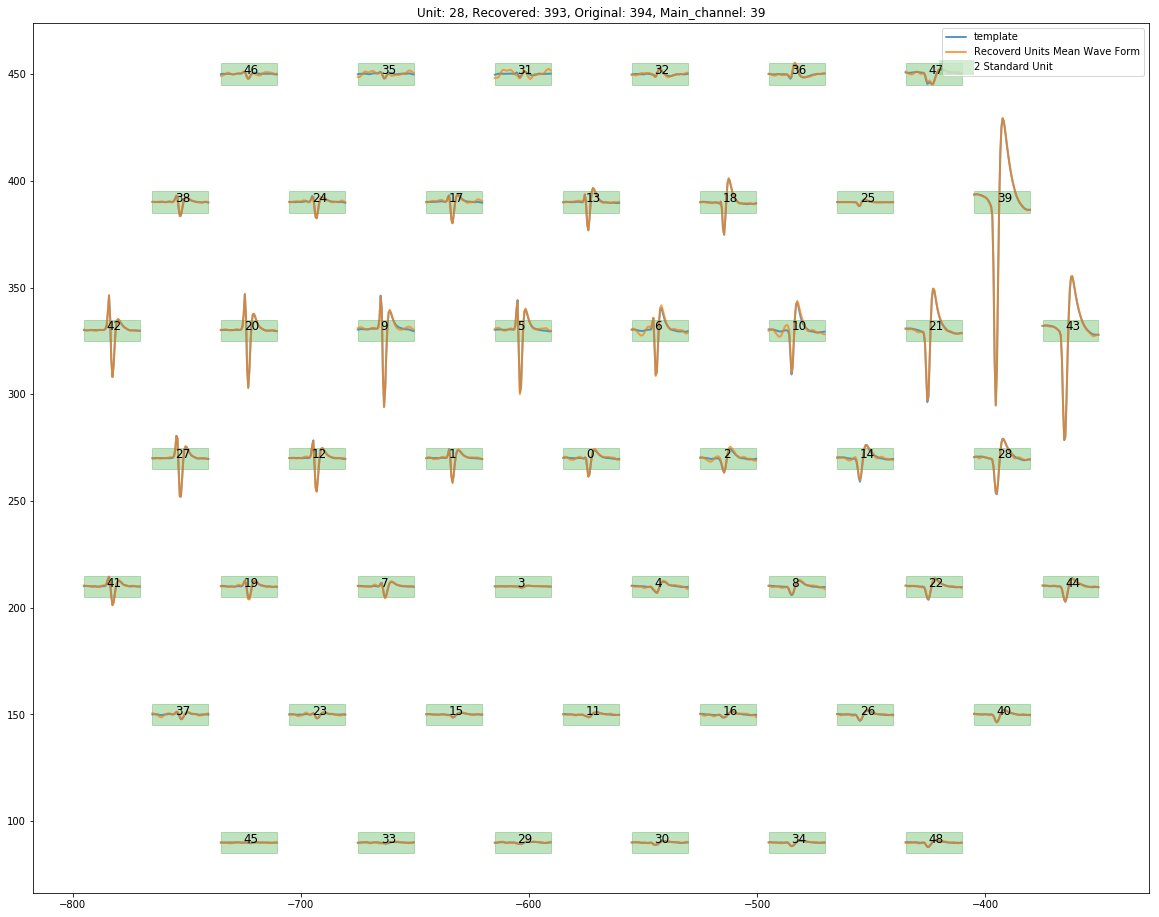

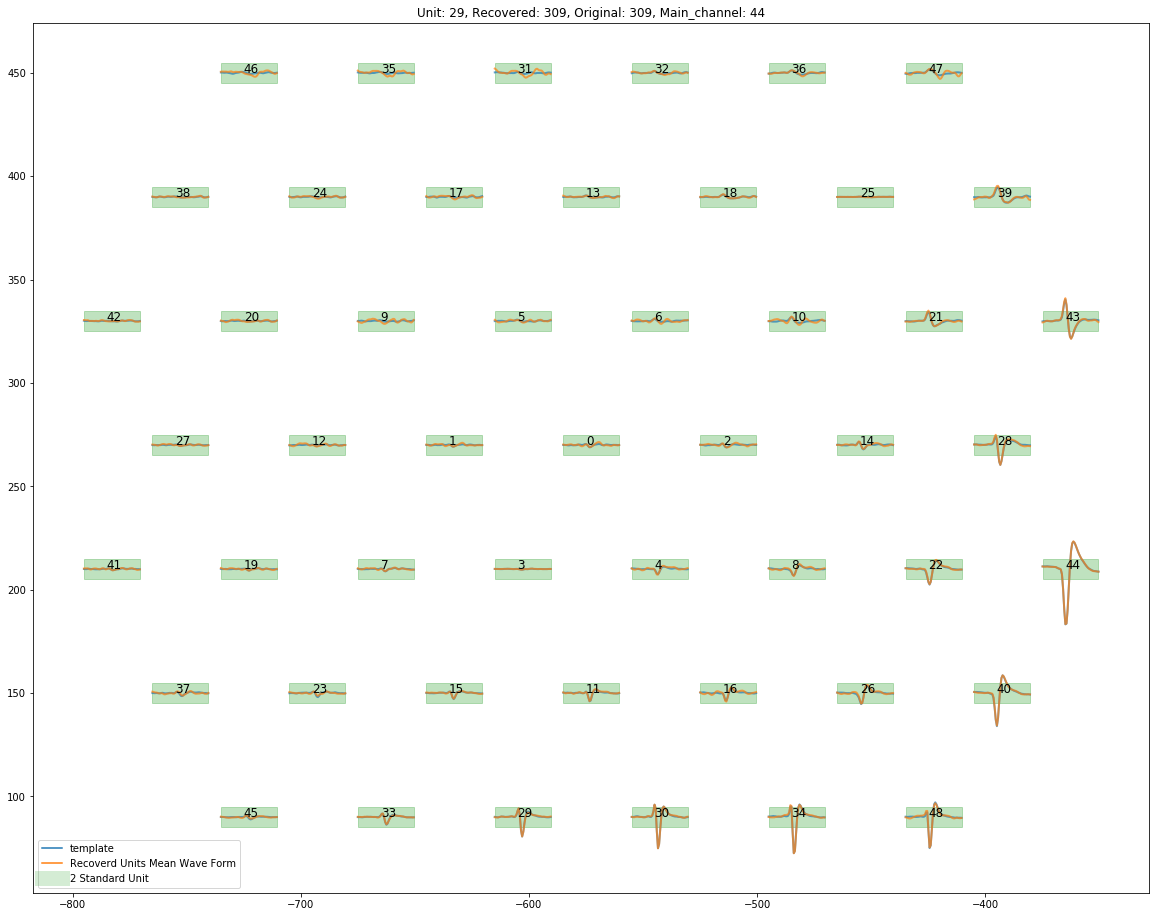

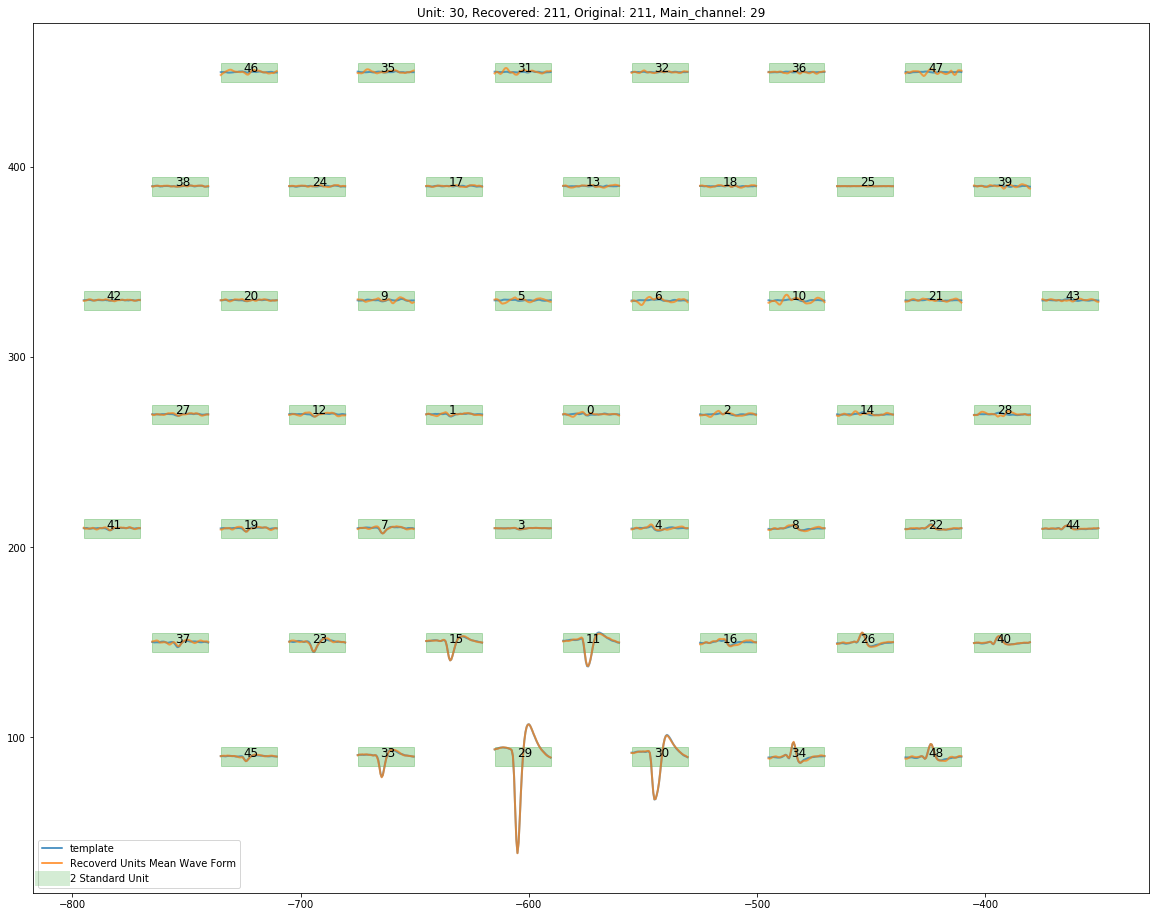

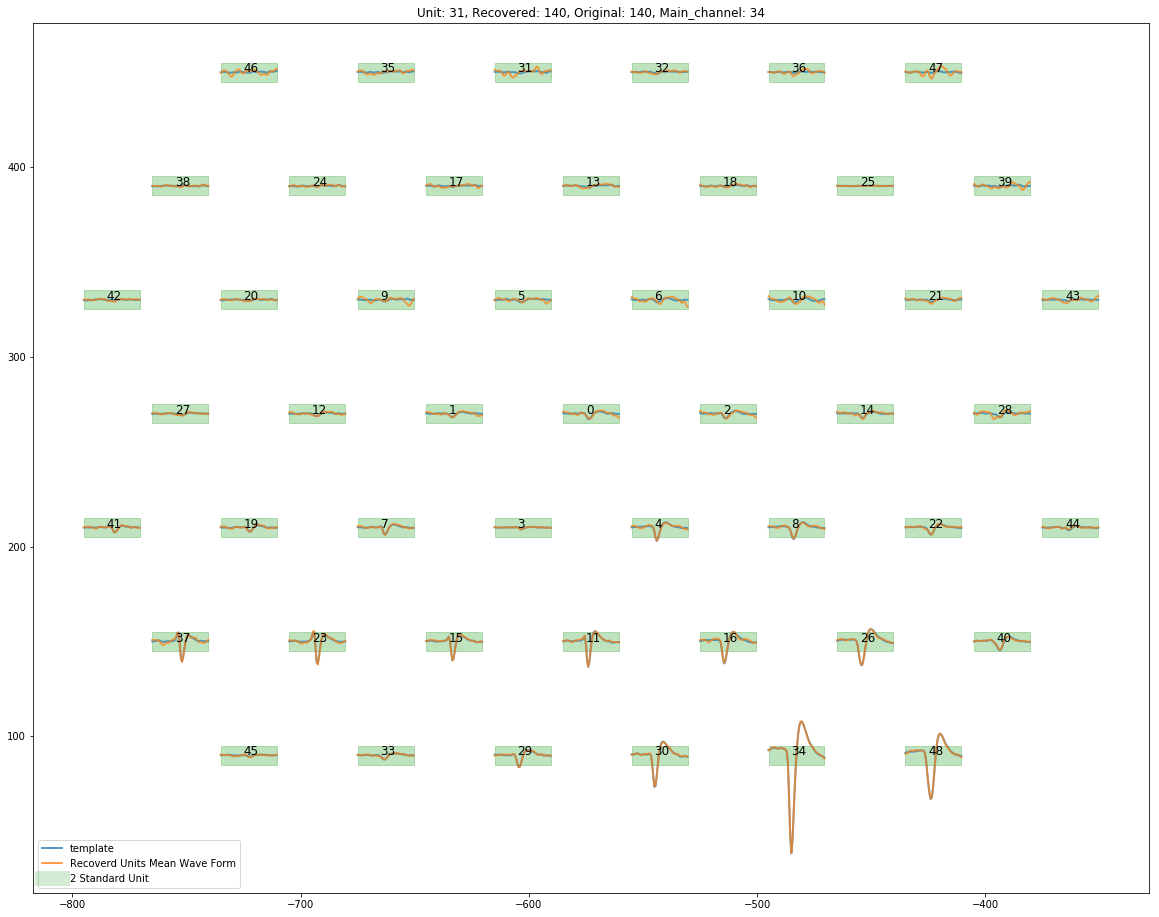

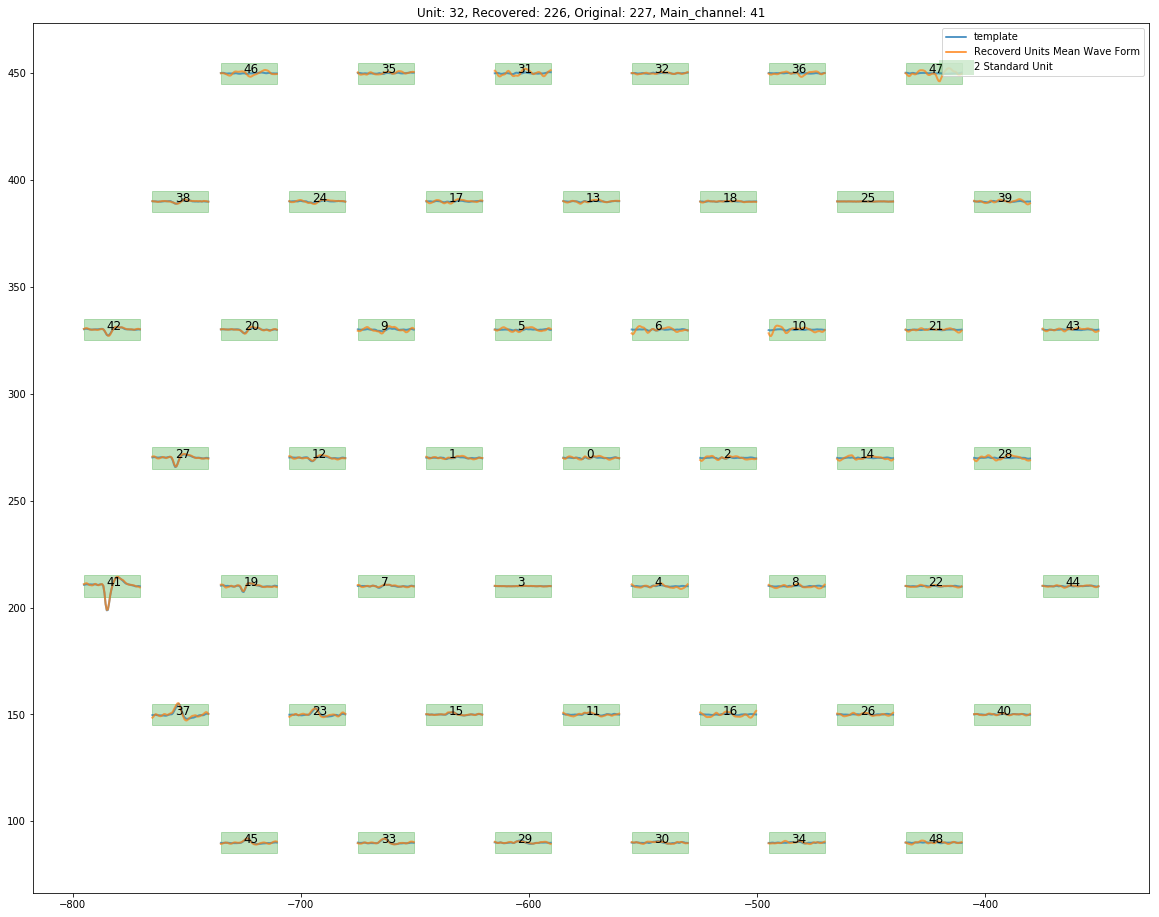

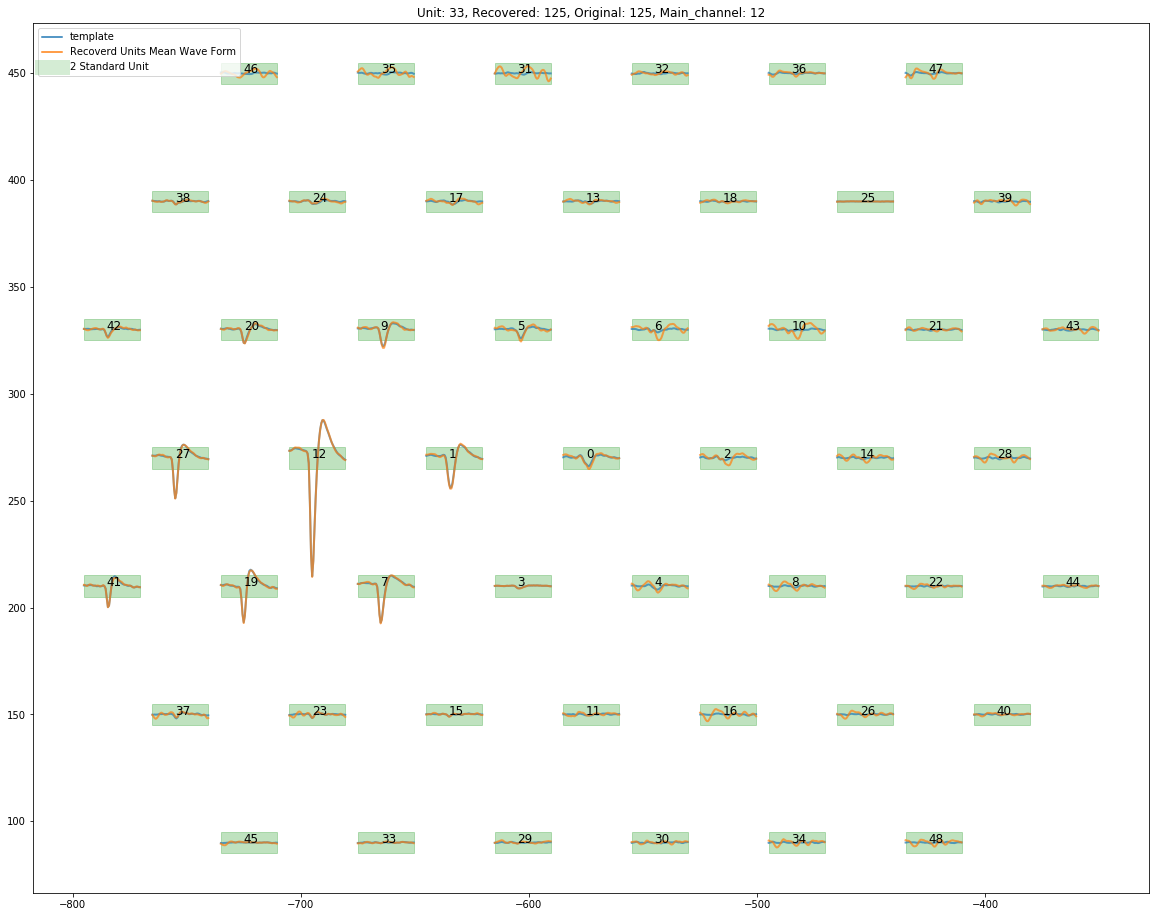

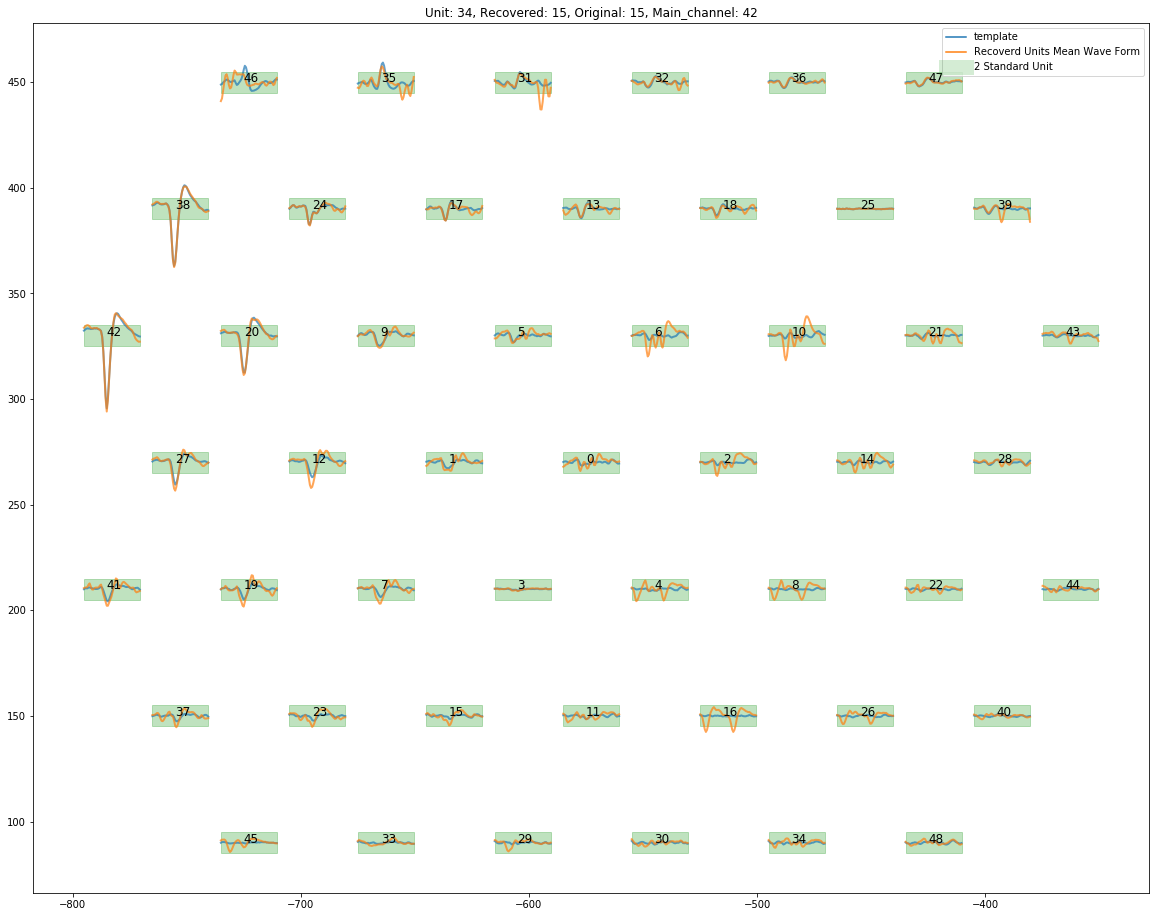

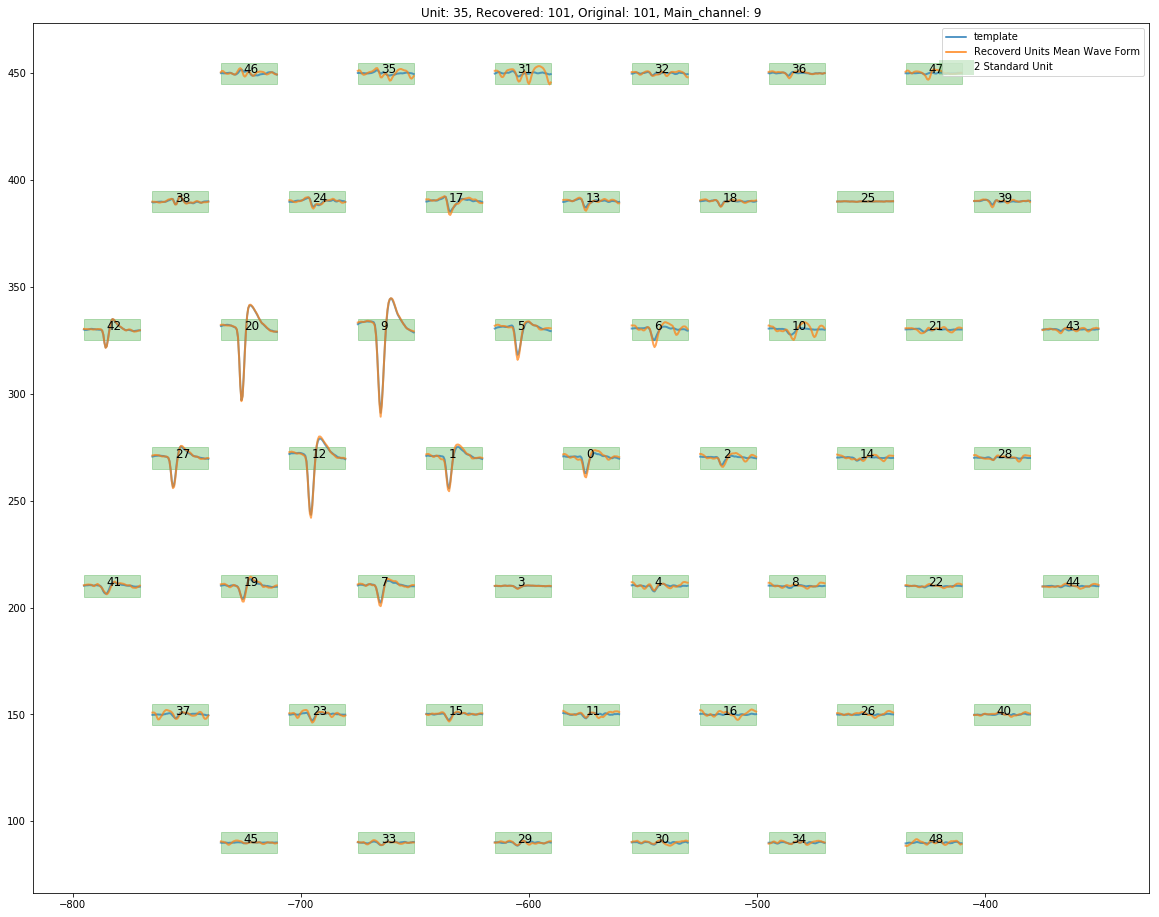

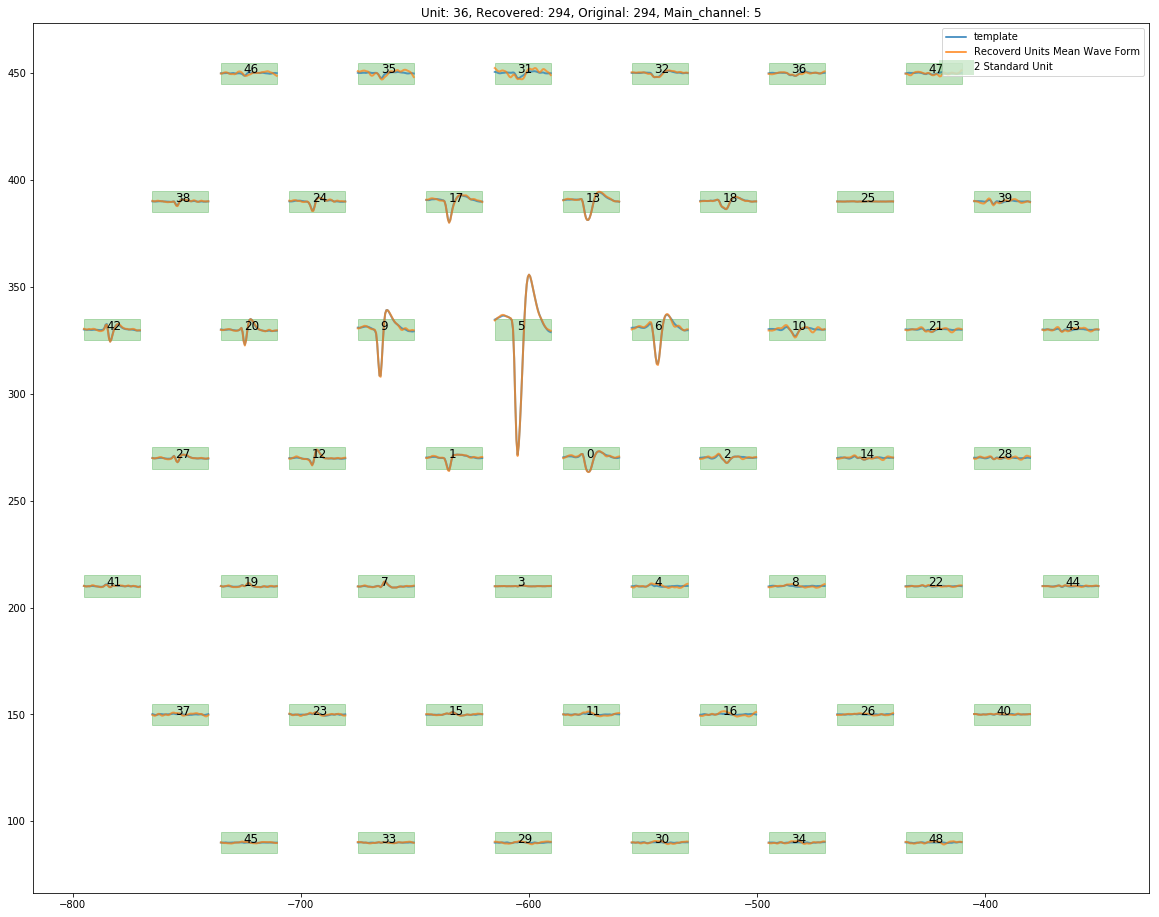

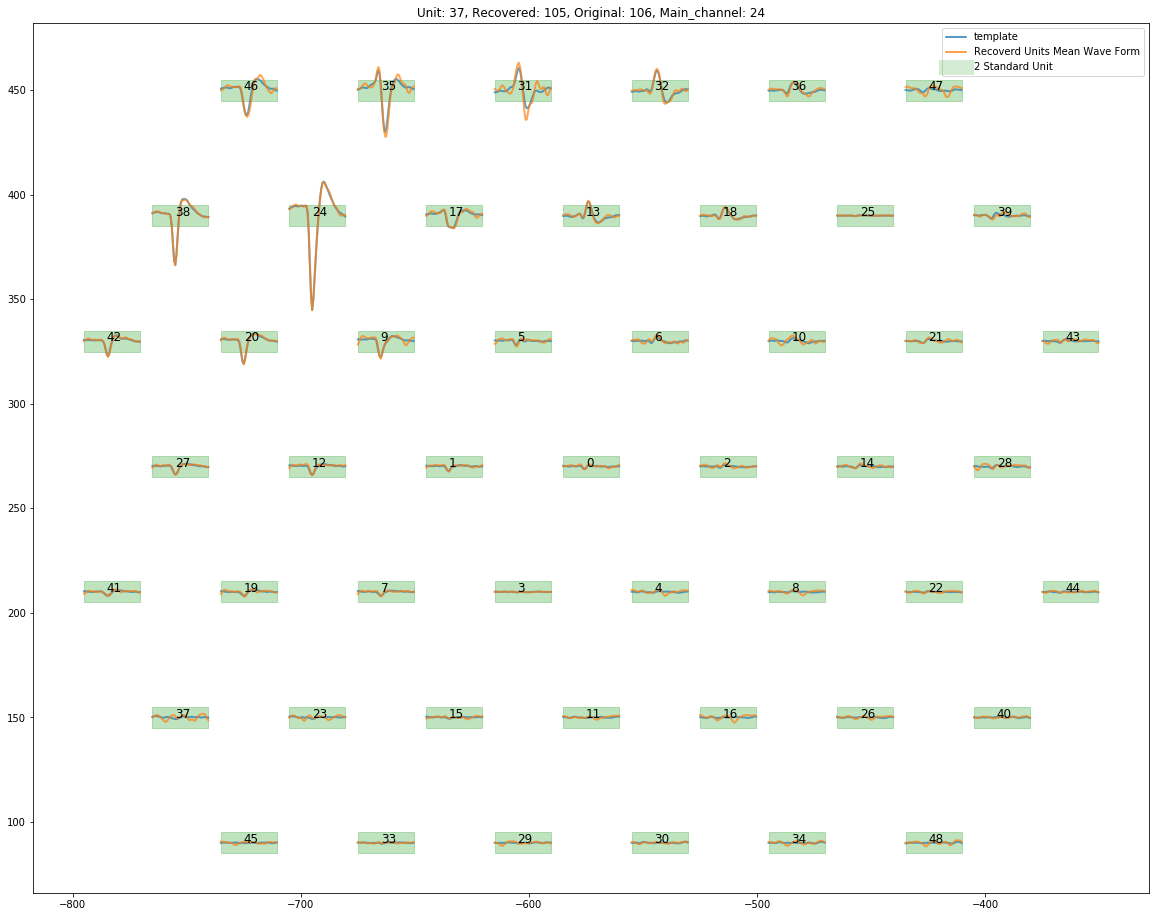

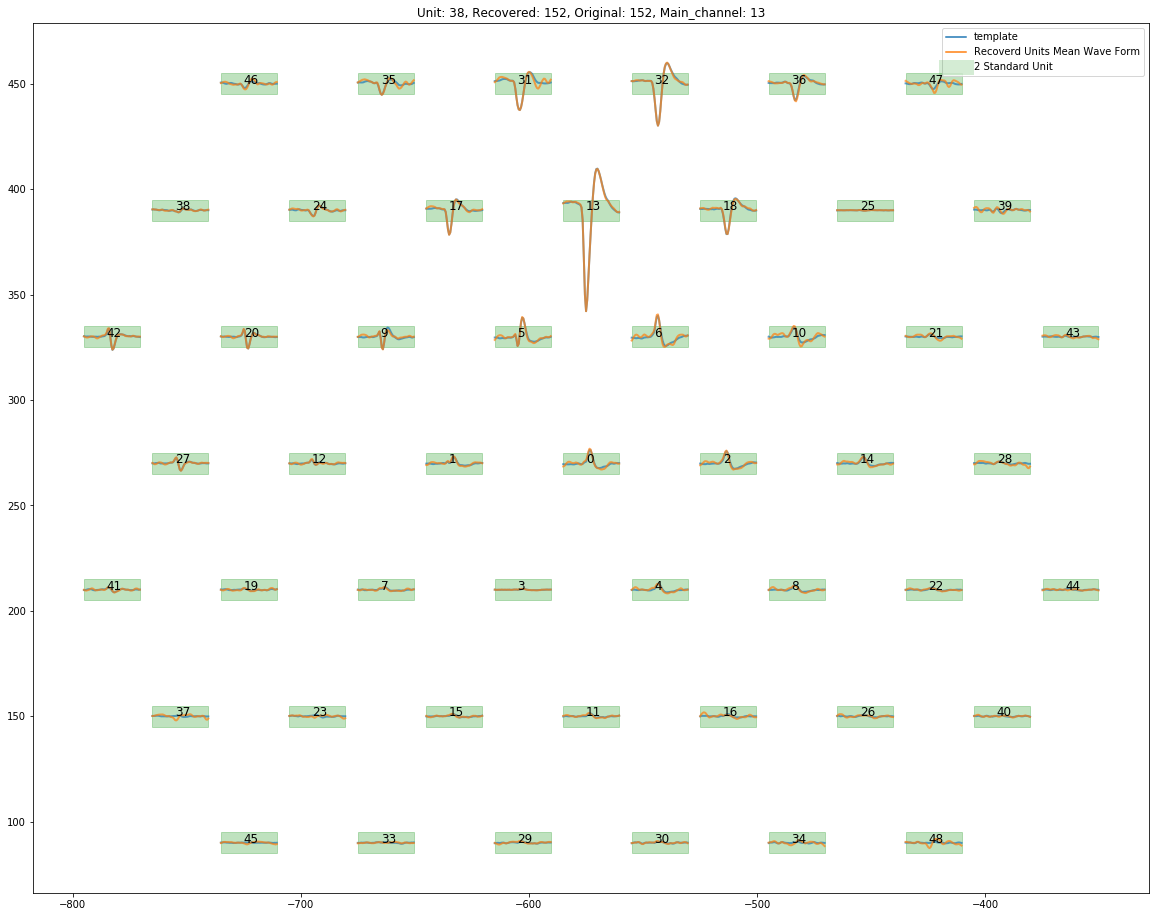

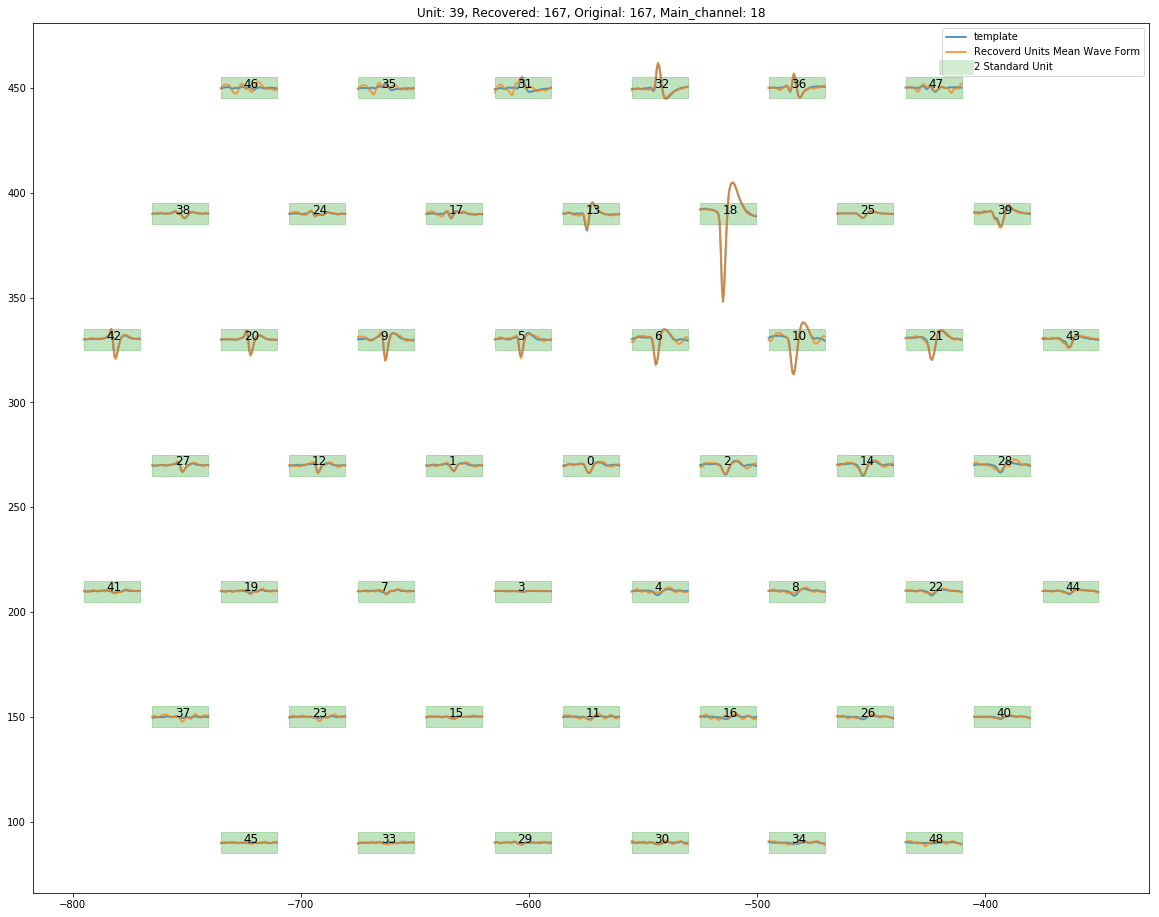

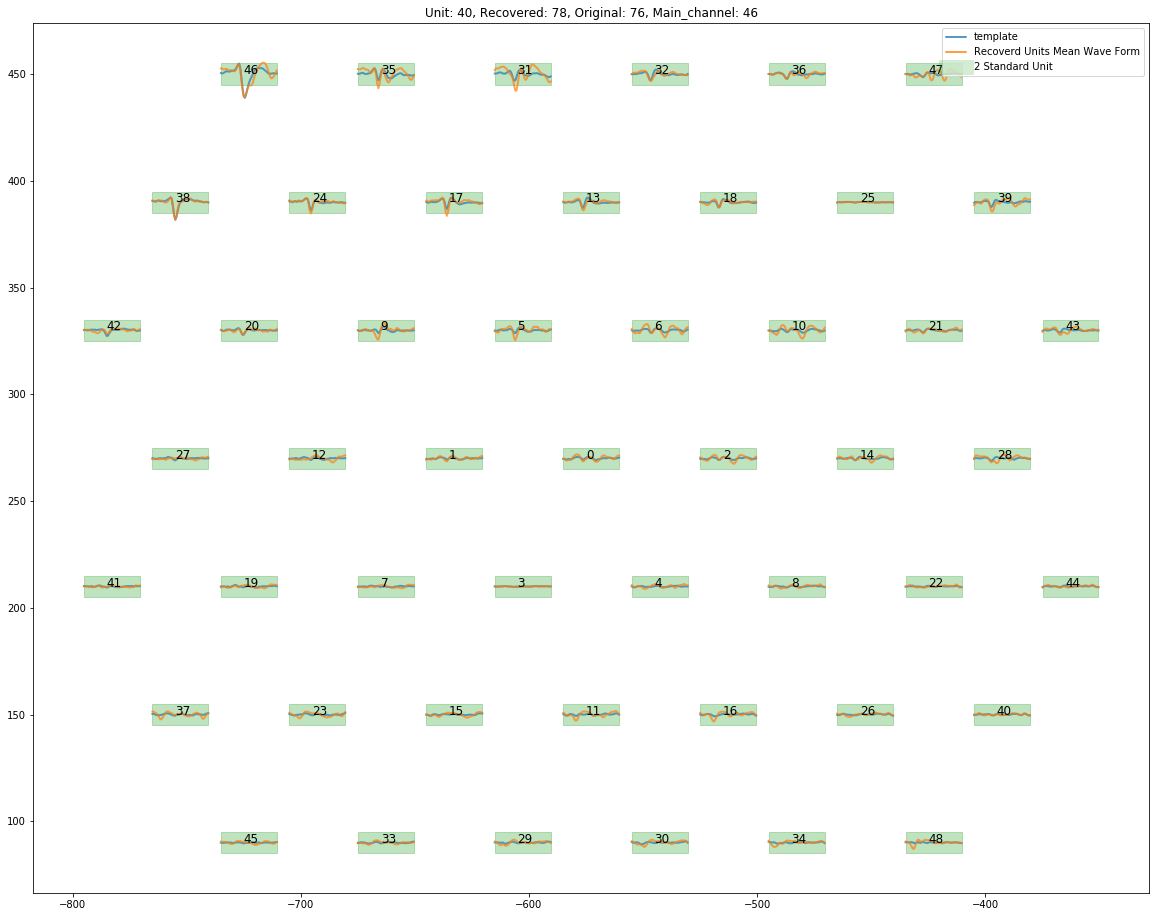

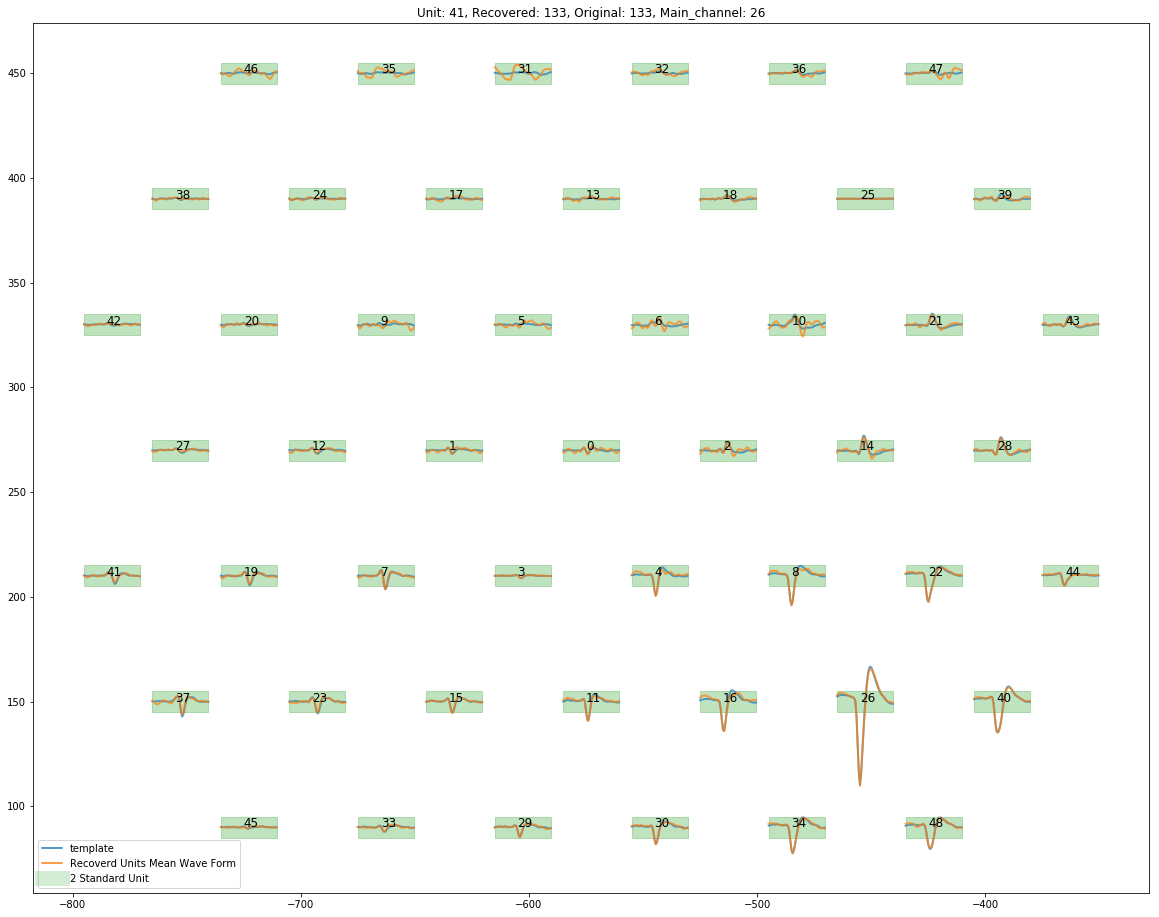

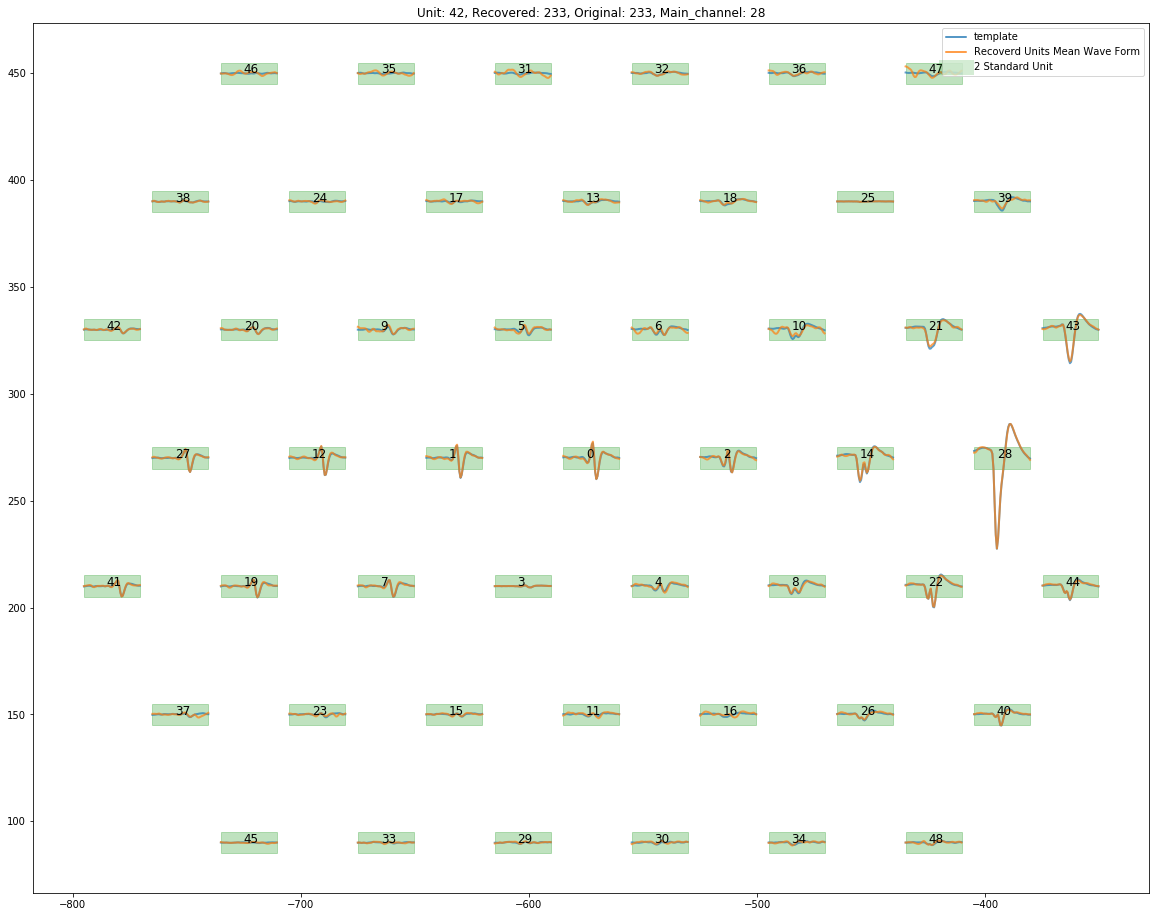

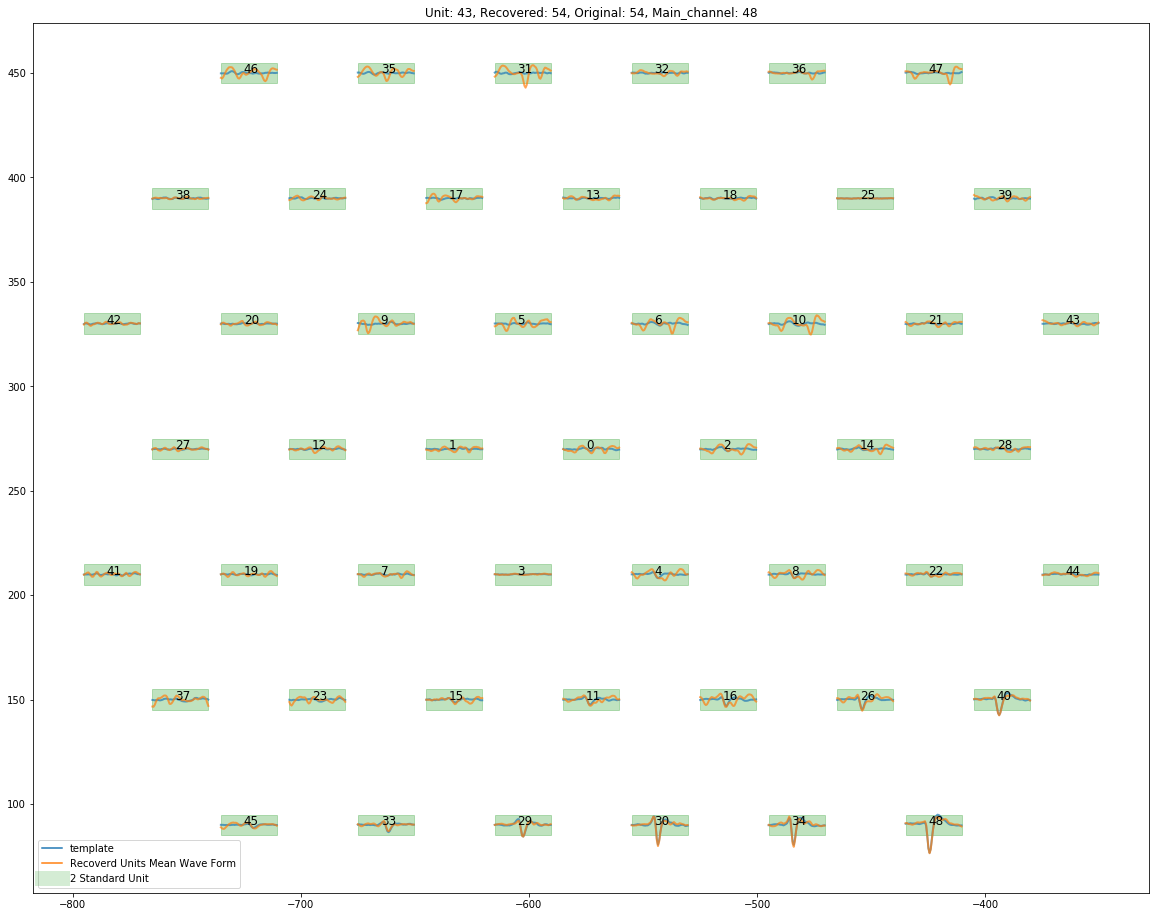

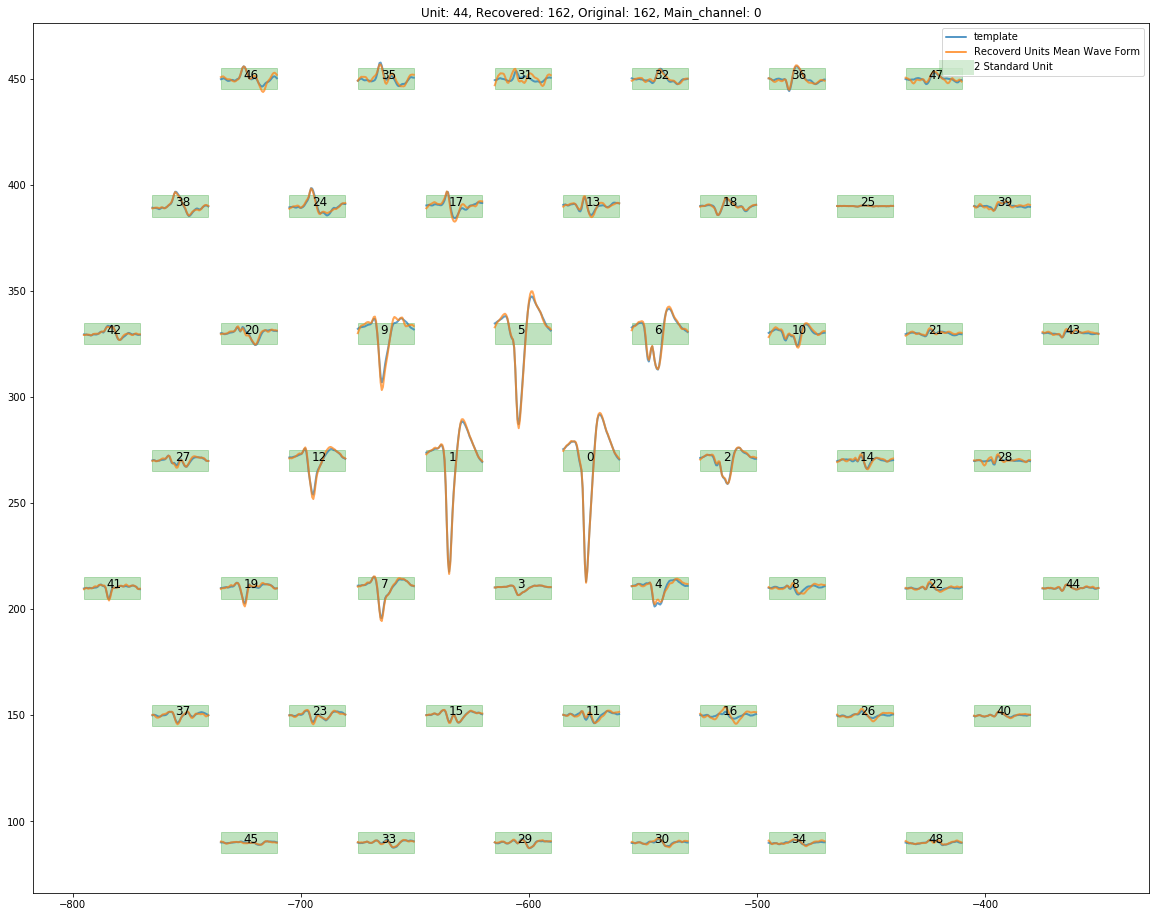

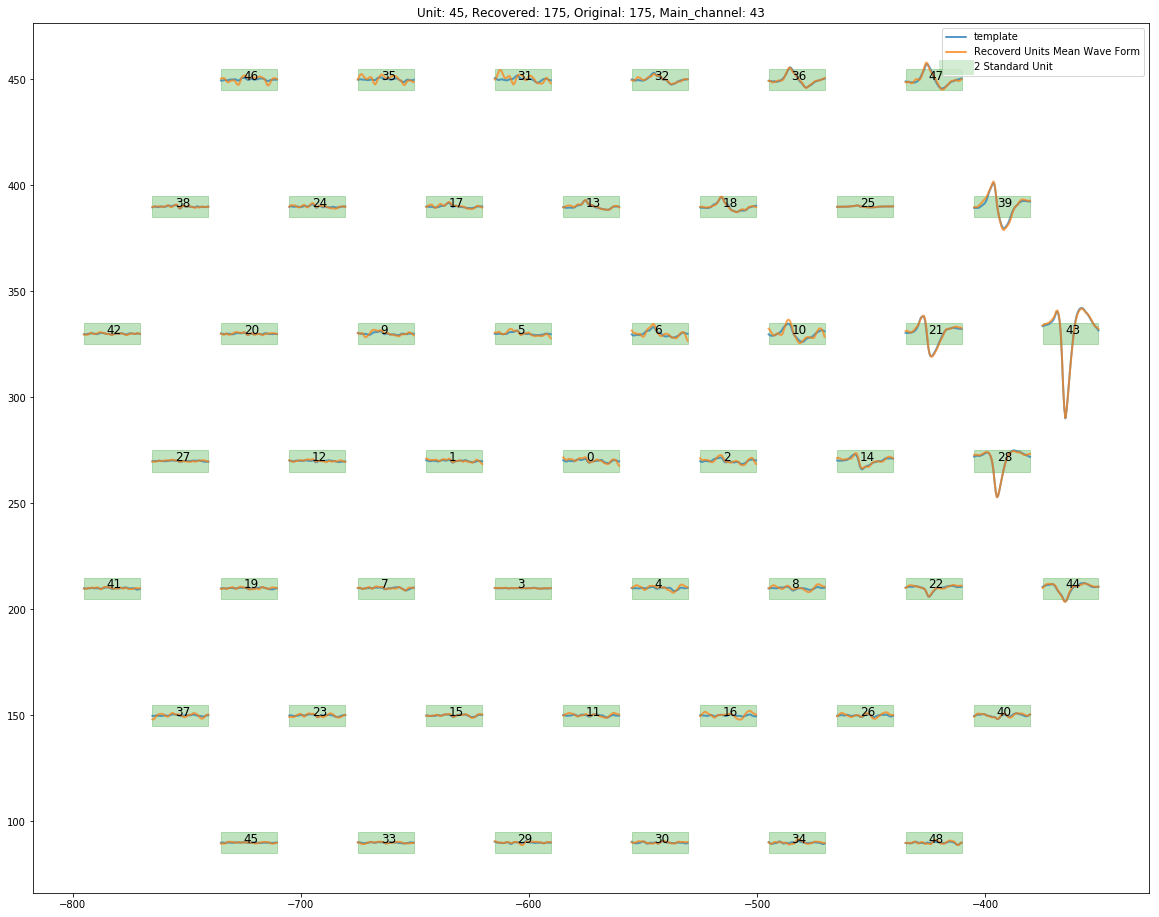

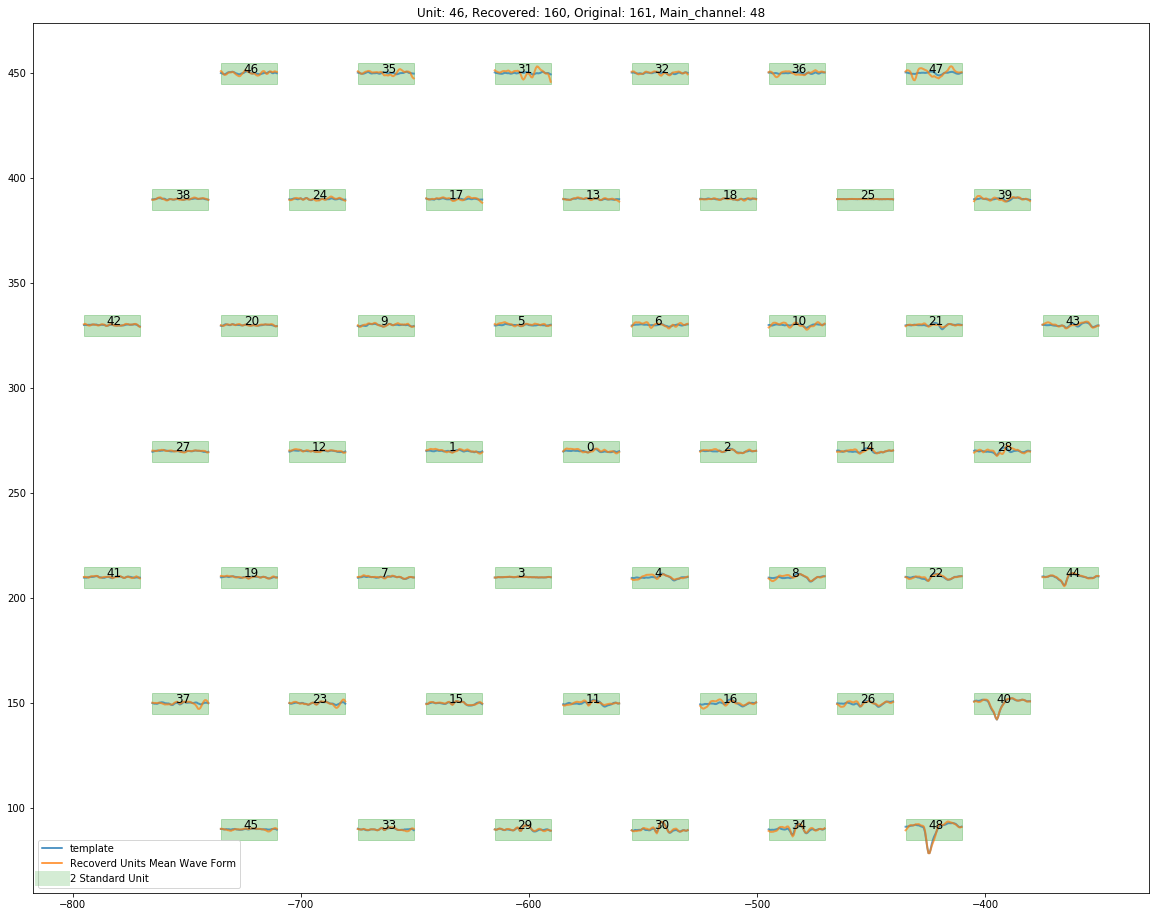

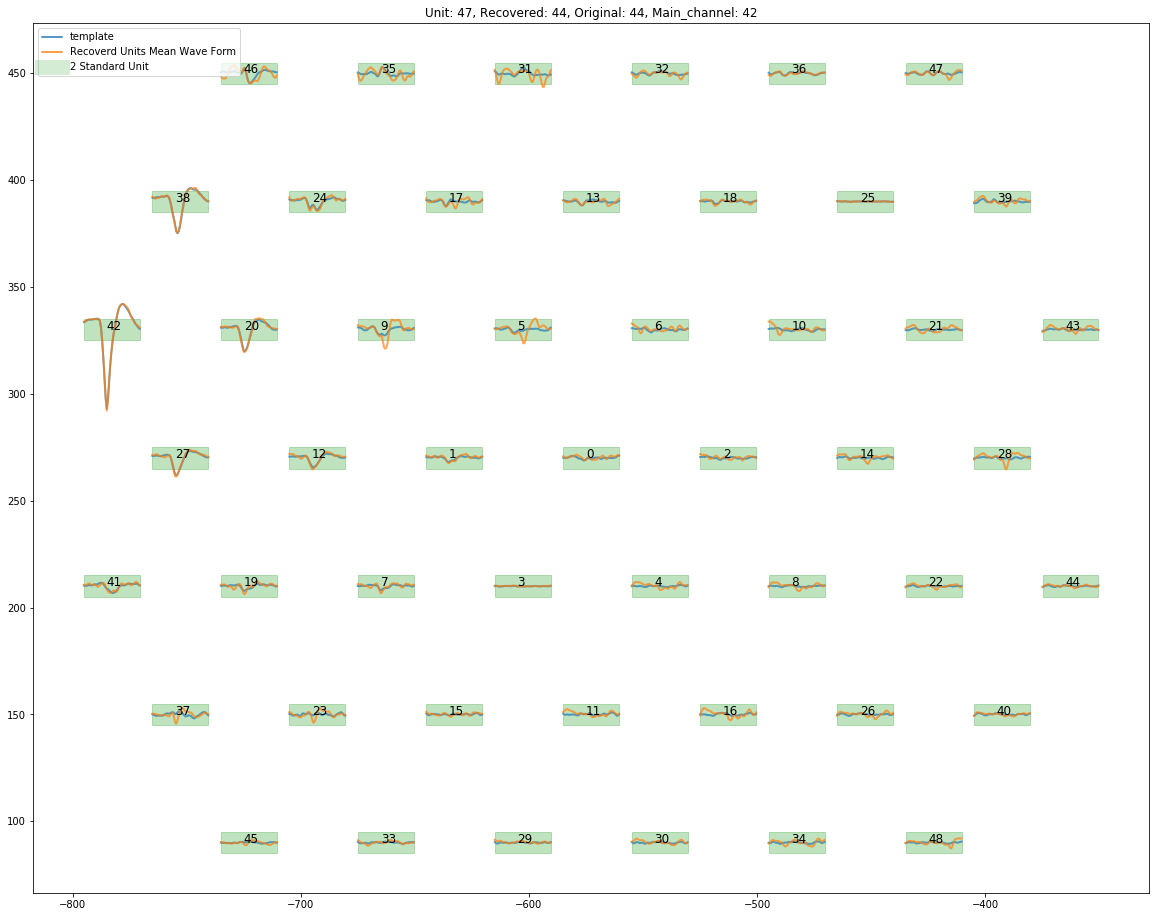

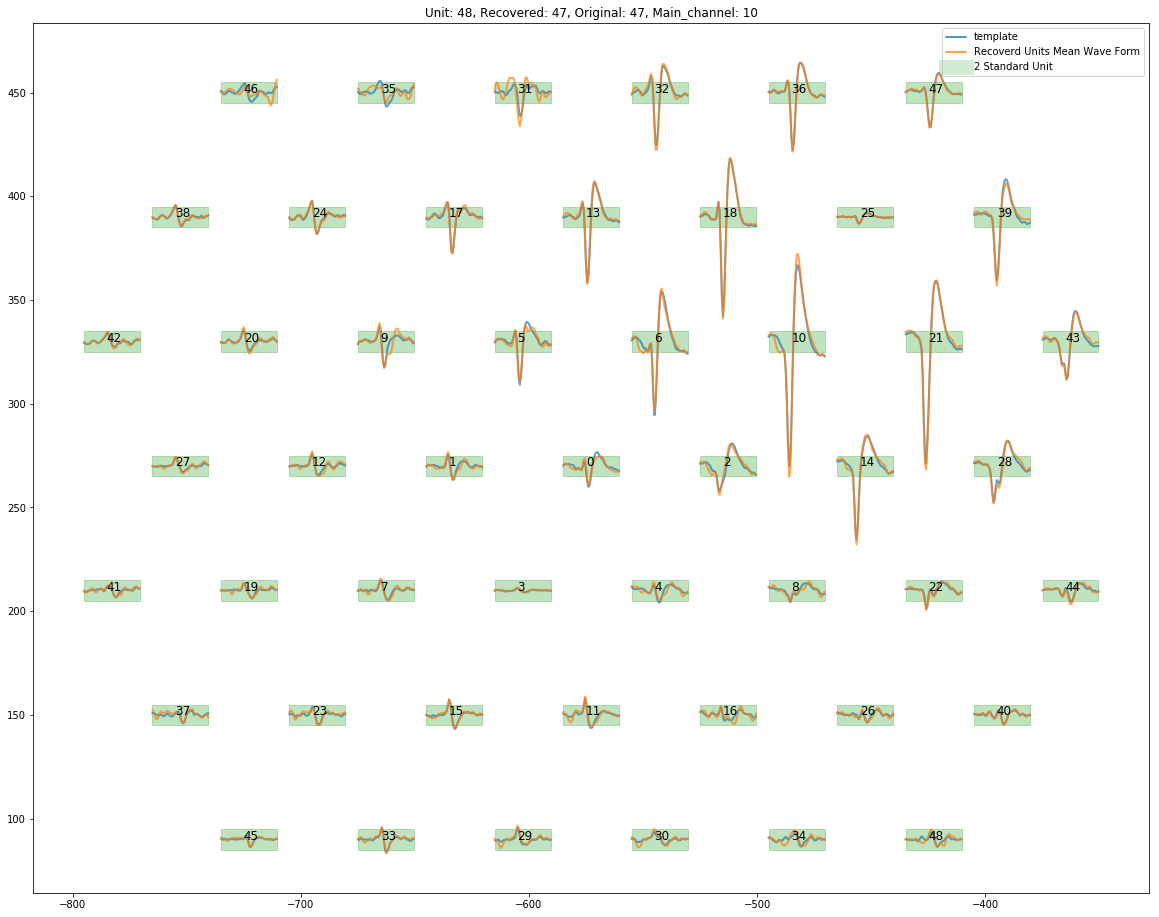

In [29]:
gold_sp_trunc = gold_sp[gold_sp[:, 0] < TOT_TIME, :]
for unit in all_units:
    print unit
    fig, ax = plt.subplots()
    sp = deconvd_sp[deconvd_sp[:, 1] == unit, 0]
    sp = sp[:, np.newaxis] + np.arange(-25, 25, 1)
    plot_spatial(geom_m, temps[:, :, unit], ax, color='C0', scale=10., squeeze=2.)
    plot_spatial(geom_m, np.mean(data[:, :][sp], axis=0), ax, color='C1', scale=10., squeeze=2.)
    plot_spatial_fill(geom_m, temps[:, :, unit] * 0, ax, color='C2', scale=10., squeeze=2.)
    plot_chan_numbers(geom_m, ax)
    # Add legends.
    legend_elements = [Line2D([0], [0], color='C0', label='template'),
                       Line2D([0], [0], color='C1', label='Recoverd Units Mean Wave Form'),
                       Line2D([0], [0], lw=15, color='C2', alpha=0.2, label='2 Standard Unit')]
    ax.legend(handles=legend_elements)
    ax.set_title('Unit: {}, Recovered: {}, Original: {}, Main_channel: {}'.format(
        unit, len(sp), np.sum(gold_sp_trunc[:, 1] == unit), m_c[unit]))
    fig.set_size_inches(20, 16)
    plt.savefig('deconv_templates_easy_unit{}.pdf'.format(unit))

In [212]:
mp.subtract_spike_train(gold_sp[:10, :])

In [47]:
_, _, c = np.linalg.svd(mwc_temps[:, :, 0])
b_ = main_channels(mwc_temps[:, :, 0])[-10:]

In [48]:
c_ = np.where(np.max(np.abs(c), 0) > np.min(np.max(np.abs(c)))*0.5)[0]
c_

array([ 2,  3,  4,  5,  7,  9, 17, 20, 21, 22, 23, 25, 33, 36, 40, 41, 42,
       45, 46, 47])

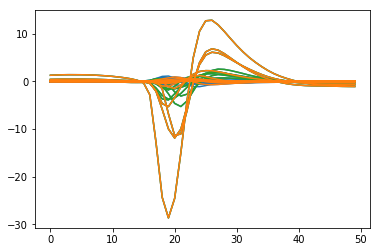

In [49]:
plt.plot(mwc_temps[:, :, 0], color='C0')
plt.plot(mwc_temps[:, b_, 0], c='C2')
plt.plot(mwc_temps[:, c_, 0], c='C1')
plt.show()

In [178]:
d1 = copy.copy(data)
d1[np.arange(0, 50) + gold_sp[:2, :1], :] -= mwc_temps[:, :, 1]
d1

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [176]:
gold_sp[:2, :2]

array([[ 116,    1],
       [1653,    1]], dtype=int32)